1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core
from statmechlib.forcefields import f_embed, f_dens, f_spline3

In [134]:
working = '../data/working'

In [135]:
# params_file = 'marinica_params'
# with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
#     param_list = pickle.load(fi)  

In [136]:
params_file = 'marinica_bs'
with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)

In [137]:
param_list

{'pair': [(1.05, 30.349520488708038, 5058.253414784672),
  (1.1500000000000001, 26.07349272068288, 4345.5821201138115),
  (1.25, 22.25228031694145, 3708.7133861569073),
  (1.35, 18.856344099214503, 3142.72401653575),
  (1.45, 15.856144889232624, 2642.690814872103),
  (1.55, 13.222143508726433, 2203.690584787738),
  (1.6500000000000001, 10.924800779426661, 1820.8001299044429),
  (1.75, 8.934577523064021, 1489.096253844003),
  (1.8499999999999999, 7.221934561369125, 1203.655760228187),
  (1.95, 5.757332716072646, 959.5554526787741),
  (2.05, 4.511232808905241, 751.87213481754),
  (2.15, 3.454095661597627, 575.682610266271),
  (2.25, 2.55638209588043, 426.0636826467382),
  (2.3499999999999996, 1.788552933484354, 298.09215558072555),
  (2.4499999999999997, 1.1787699109355287, 196.46165182258807),
  (2.55, 0.8293118452061883, 138.218640867698),
  (2.65, 0.577119035693979, 96.18650594899648),
  (2.75, 0.4111360678627989, 68.52267797713313),
  (2.8499999999999996, 0.30130276179913196, 50.2171

In [138]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [791]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [792]:
# targets['eos']['box'] = targets['eos']['box'][5:6]
# targets['eos']['xyz'] = targets['eos']['xyz'][5:6]
# targets['eos']['temp'] = targets['eos']['temp'][5:6]
# targets['eos']['beta'] = targets['eos']['beta'][5:6]
# targets['eos']['energy'] = targets['eos']['energy'][5:6]
# stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][5:6]

In [793]:
# targets['eos']['box'] = targets['eos']['box'][6:7]
# targets['eos']['xyz'] = targets['eos']['xyz'][6:7]
# targets['eos']['temp'] = targets['eos']['temp'][6:7]
# targets['eos']['beta'] = targets['eos']['beta'][6:7]
# targets['eos']['energy'] = targets['eos']['energy'][6:7]
# stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][6:7]

In [794]:
targets['eos']['box'] = targets['eos']['box'][0:1]
targets['eos']['xyz'] = targets['eos']['xyz'][0:1]
targets['eos']['temp'] = targets['eos']['temp'][0:1]
targets['eos']['beta'] = targets['eos']['beta'][0:1]
targets['eos']['energy'] = targets['eos']['energy'][0:1]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][0:1]

In [795]:
# targets['eos']['box'] = targets['eos']['box'][4:5]
# targets['eos']['xyz'] = targets['eos']['xyz'][4:5]
# targets['eos']['temp'] = targets['eos']['temp'][4:5]
# targets['eos']['beta'] = targets['eos']['beta'][4:5]
# targets['eos']['energy'] = targets['eos']['energy'][4:5]
# stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][4:5]

In [796]:
# targets['eos']['box'] = targets['eos']['box'][4:6]
# targets['eos']['xyz'] = targets['eos']['xyz'][4:6]
# targets['eos']['temp'] = targets['eos']['temp'][4:6]
# targets['eos']['beta'] = targets['eos']['beta'][4:6]
# targets['eos']['energy'] = targets['eos']['energy'][4:6]
# stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][4:6]

In [797]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:5]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:5]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:5]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:5]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:5]

In [798]:
# targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:6]
# targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:6]
# targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:6]
# targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:6]
# targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:6]
# stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:6]

In [799]:
# targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
# targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
# targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
# targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
# targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
# stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
# len(targets['eos_bcc']['energy']), len(stats_bspline['eos_bcc']['energy'])

In [800]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]

In [802]:
#edens_knots = list(np.linspace(1.05, 4.25, 5))
edens_knots = list(np.linspace(1.05, 4.45, 35))
#edens_knots = list(np.linspace(1.05, 5.25, 43))
pair_knots = list(np.linspace(1.05, 5.05, 41))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05]


In [803]:
def Dbs(n, order, lo_bound=[], hi_bound=[]):
    """B-spline penalty matrix
    """
    
    pen = {0:[1.0],
           1:[1.0, -1.0],
           2:[1.0, -2.0, 1.0],
           3:[1.0, -3.0, 3.0, -1.0],
           4:[1.0, -4.0, 6.0, -4.0, 1.0]}   
    
    n_lo = len(lo_bound)
    n_hi = len(hi_bound)
    n_tot = n + n_lo + n_hi

    # Extended penalty matrix
    P = np.zeros((n_tot, n_tot), dtype=float)
    
    for i in range(n_tot-order):
        P[i, i:i+1+order] = pen[order]

    # Select inner part of the penalty matrix without constraints
    if n_hi > 0:
        D = np.copy(P[:,n_lo:-n_hi])
    else:
        D = np.copy(P[:,n_lo:])

    # Apply low and high constraints and sum them into 1D array
    C = np.zeros((n_tot), dtype=float)
    if n_lo > 0:
        C += P[:, :n_lo].dot(np.array(lo_bound))
    if n_hi > 0:
        C += P[:,-n_hi:].dot(np.array(hi_bound))
        
    #print('c',C)
    

    return D, C

In [804]:
def penalty_matrix(partitions):
    """Constructs b-spline penalty matrix for a given Hamiltonian
    
    The resulting matrix is constructed for 1 or more b-splines
    and may exclude designated parameters. 

    Parameters
    ----------
    n : int, len(self.coef_)
        number of parameters defining number of matrix columns
    order : int or list of ints
        order of the stiffness penalty. If list of values is provided,
        multiple b-splines will be penalized by the given orders.
    exclude : list of ints
        List of indices of parameters to be excluded from penalties
    bounds : list of lists
        For each b-spline, have a list of virtual 
    lower_bound : 1D array-like
        defines virtual parameter values below the fitting region
    upper_bound : 1D array-like
        defines virtual parameter values above the fitting region
        
    Returns
    -------
    Dsqr : ndarray, shape (n_coeffs, n_coeffs)
        Square of the penalty matrix
    """
    
    penalty_degree = {0, 1, 2, 3, 4}
    
    # Penalty matrices and vectors for Hamiltonian partitions
    D_parts = []
    C_parts = []
    for n_part, p_degree, scale, lo_bound, hi_bound in partitions:
        if p_degree is None: # no penalty
            dd = np.zeros((n_part, n_part), dtype=float)
            cc = np.zeros((n_part), dtype=float)
        elif p_degree in penalty_degree:
            dd, cc = Dbs(n_part, p_degree, lo_bound=lo_bound, hi_bound=hi_bound)
        else:
            raise ValueError("Unknown penalty: {}".format(ptype))
        if scale is not None:
            # scale coefficient penalty
            dd = np.diag(scale).dot(dd)

        D_parts.append(dd)
        C_parts.append(cc)
        #print(cc.shape, dd.shape)

    # Penalty matrix as a block diagonal from submatrices
    C = np.concatenate(C_parts)
    D = block_diag(*D_parts)
    #print('shapes', C.shape, D.shape)
    #print('C', C)
    
    # Square of penalty matrix needed in loss and its derivatives
    CC = C.dot(C)
    CD = 2.0*C.dot(D)
    DD = D.T.dot(D)
    #print('shapes2', CD.shape, DD.shape, CC.shape)

    return DD, CD, CC

In [805]:
len(pair_knots), len(edens_knots)

(41, 35)

In [806]:
# #scale = np.sqrt(np.logspace(-3, -0, len(pair_knots)))
# #[(s, k) for s, k in zip(scale, pair_knots)]


# # 3rd order penalty for larger distances
# partitions = []
# partitions.append([1, None, None, None, None]) # Embedding function - no penalty
# partitions.append([len(pair_knots), 3, scale, [], []])
# partitions.append([len(pair_knots), 3, None, [], []])
# partitions.append([len(edens_knots), 3, None, [], []])

# Dp3, Cp3, c3 = penalty_matrix(partitions)
# print(c3, Cp3, Dp3[:])

# # 2nd order penalty for larger distances
# partitions = []
# partitions.append([1, None, None, None, None]) # Embedding function - no penalty
# partitions.append([len(pair_knots), 3, None, [], []])
# partitions.append([len(edens_knots), 3, None, [], []])

# Dp2, Cp2, c2 = penalty_matrix(partitions)
# Dp3.shape, Dp2.shape

In [807]:
def make_input_matrices(target, stats, keytrj=None, combined=0.0):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X0 = []
    X1 = []
    # vector of dependent variable (configurational energies)
    y = []
    # weights of individual trajectories
    weights = []
    # vector of inverse temperatures
    beta = []
    # bounds of trajectories in the overall design matrix
    bounds = []

    keys = list(target.keys())
    
    if keytrj is not None:
        keys = keytrj
    else:
        keys = list(target.keys())

    max_features = 0
    max_atoms = 0
    for key in keys:
        
        w = target[key]['weight']
        
        # eliminate trajectories with 0 weight
        if w == 0.0:
            continue

        lo_bound = len(y)
        
        # cycle over samples (configurations)

        for i, (config, energy, bb) in enumerate(zip(stats[key]['energy'], target[key]['energy'], target[key]['beta'])):
            
            # add energy
            y.append(energy)
            beta.append(bb)
            #weights.append(w)
            
            # create an array of independent variables
            x_vars = []
            
            # embedding for additive model
            #x_vars += [config[0][0], config[1][0]]

            # pair interactions b-spline stats. Adds a list of descriptors
            x_vars += list(0.5*config[2])
            
            # per atom edens b-spline stats. Adds an array (n_features, n_atoms)
            xn_vars = config[3]
            
            max_features = max(max_features, xn_vars.shape[0])
            max_atoms = max(max_atoms, xn_vars.shape[1])

            X0.append(x_vars)
            X1.append(xn_vars)
            
        bounds.append(slice(lo_bound, len(y), 1))
        weights.append(w)
    
    if combined > 0.0:
        # add trajectory of zeros by replicating 'inf'
        
        config = stats['inf']['energy'][0]
        energy = target['inf']['energy'][0]
        bb = target['inf']['beta'][0]
        
        for i in range(200):
            # add energy
            y.append(energy)
            beta.append(bb)
            #weights.append(w)
            
            # create an array of independent variables
            x_vars = []
            
            # embedding for additive model
            #x_vars += [config[0][0], config[1][0]]

            # pair interactions b-spline stats. Adds a list of descriptors
            x_vars += list(0.5*config[2])
            
            # per atom edens b-spline stats. Adds an array (n_features, n_atoms)
            xn_vars = config[3]
            
            max_features = max(max_features, xn_vars.shape[0])
            max_atoms = max(max_atoms, xn_vars.shape[1])

            X0.append(x_vars)
            X1.append(xn_vars)
            
        bounds.append(slice(0, len(y), 1))
        weights.append(combined)

    # Additive features to a 2D array in X[0] 
    X0 = np.array(X0)
    X = [X0]
    
    # Non-additive features to a 3D array to be filled with density function statistics.
    # Organize the dimensions as (n_samples, n_atoms, n_features) so that dot product
    # between edens parameters and the array to compute density on individual atoms
    # is along the last (contiguous) dimension.
    X.append(np.zeros((len(X1), max_atoms, max_features), dtype=float))
    for i in range(len(X1)):
        X[1][i,:X1[i].shape[1],:] = X1[i].T
    
    y = np.array(y)
    
    assert len(y) == len(X[0]), "Shapes of y and X[0] do not match"
    assert len(y) == len(X[1]), "Shapes of y and X[1] do not match."
    
    print('bounds', bounds)
    print('weights', weights)

    return X, y, np.array(weights), np.array(beta), bounds

In [808]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [997]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.0 #0.1
targets['eos']['weight'] = 0.0 #1e-4
targets['eos_bcc']['weight'] = 0.0 #0.1
targets['relax']['weight'] = 10.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_300K']['weight'] = 5.0
targets['bcc_npt_langevin_3700K']['weight'] = 3.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 3.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 10.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 5.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 0.0),
 ('bain', 0.0)]

In [998]:
targets['eos']['temp'][0] = 10000.0
targets['eos']['energy'][0] = 20000.0
targets['eos']['energy']

[20000.0]

## Start with preoptimized parameters obtained from an additive model

In [813]:
def _tpf_to_bspline(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = len(penalty) -1 #order
    P = np.zeros((n_tot, n_tot), dtype=float)
    for i in range(n_tot):
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot:
                continue
            P[i, i+j-o] = p

    Pinv = np.linalg.inv(P.T)
    on = np.zeros(n_tot)
    on[-1] = 1.0
    return Pinv.dot(on)

In [814]:
#edens_coeffs = _tpf_to_bspline(len(edens_knots)*8+1)[8::8]
edens_coeffs = _tpf_to_bspline(len(edens_knots))
edens_coeffs

array([7.770e+03, 7.140e+03, 6.545e+03, 5.984e+03, 5.456e+03, 4.960e+03,
       4.495e+03, 4.060e+03, 3.654e+03, 3.276e+03, 2.925e+03, 2.600e+03,
       2.300e+03, 2.024e+03, 1.771e+03, 1.540e+03, 1.330e+03, 1.140e+03,
       9.690e+02, 8.160e+02, 6.800e+02, 5.600e+02, 4.550e+02, 3.640e+02,
       2.860e+02, 2.200e+02, 1.650e+02, 1.200e+02, 8.400e+01, 5.600e+01,
       3.500e+01, 2.000e+01, 1.000e+01, 4.000e+00, 1.000e+00])

In [815]:
b_preoptimized = [-3.66794696e-01,  4.06660863e-05,  4.55432192e+03,  3.81233526e+03,
        3.13457452e+03,  2.52103968e+03,  1.97173074e+03,  1.48664767e+03,
        1.06579047e+03,  7.09159114e+02,  4.16753580e+02,  1.88573853e+02,
        2.41578061e+01, -8.10170350e+01, -1.38288040e+02, -1.62295166e+02,
       -1.65451663e+02, -1.59888378e+02, -1.52679937e+02, -1.39059049e+02,
       -1.26124774e+02, -1.17219033e+02, -1.04327206e+02, -8.49009558e+01,
       -6.37485981e+01, -4.78623412e+01, -3.73348139e+01, -2.64590603e+01,
       -1.70659604e+01, -1.42414244e+01, -1.81406282e+01, -2.33807912e+01,
       -2.36385066e+01, -2.13661005e+01, -1.65315254e+01, -1.21306670e+01,
       -1.12774279e+01, -7.76031264e+00, -3.39803967e+00,  2.89809615e+00,
        5.21035097e+00,  1.70758787e+00,  8.85701451e-01,  1.27989801e+00,
        4.04308424e+00]

b_preoptimized = [
    -2.25564987e-01,  5.53471774e-05,  2.25541375e+03,  1.87319444e+03,
        1.52245661e+03,  1.20320028e+03,  9.15425419e+02,  6.59132036e+02,
        4.34320116e+02,  2.40989652e+02,  7.91406346e+01, -5.12269452e+01,
       -1.50194991e+02, -2.18597091e+02, -2.58686101e+02, -2.74078279e+02,
       -2.69861457e+02, -2.53982776e+02, -2.36493980e+02, -2.19246225e+02,
       -2.00531784e+02, -1.79009846e+02, -1.55497117e+02, -1.32694786e+02,
       -1.11402428e+02, -9.23235147e+01, -7.65468525e+01, -6.42617727e+01,
       -5.51831766e+01, -4.82737014e+01, -4.21720863e+01, -3.60158538e+01,
       -3.01743175e+01, -2.53604141e+01, -2.05869266e+01, -1.60165503e+01,
       -1.35593001e+01, -1.01858959e+01, -4.77285549e+00,  1.66505117e-01,
        9.71591796e-01, -1.81329966e+00, -3.46311117e+00, -3.49135492e+00,
       -1.67856521e+00
]

b_preoptimized = [
    -8.62142614e-01,  5.76185952e-04,  2.60678195e+03,  2.21333078e+03,
        1.85091762e+03,  1.51954248e+03,  1.21920534e+03,  9.49906210e+02,
        7.11645092e+02,  5.04421987e+02,  3.28236896e+02,  1.83089821e+02,
        6.89200289e+01, -1.49069956e+01, -7.02022078e+01, -1.00158659e+02,
       -1.09874134e+02, -1.07862489e+02, -1.04183739e+02, -1.00154277e+02,
       -9.34934573e+01, -8.31140399e+01, -7.01324477e+01, -5.73733960e+01,
       -4.53998654e+01, -3.46167922e+01, -2.61191305e+01, -2.03448417e+01,
       -1.72869419e+01, -1.60760416e+01, -1.53674281e+01, -1.43398461e+01,
       -1.31226750e+01, -1.20232162e+01, -1.02405430e+01, -8.15803964e+00,
       -7.81912304e+00, -6.22702947e+00, -2.10738403e+00,  1.68612203e+00,
        1.43191260e+00, -1.97196751e+00, -3.93012775e+00, -3.71908056e+00,
       -1.84930892e+00
]

b_preoptimized = [
    -6.46003130e-01,  7.85871765e-06,  3.15534395e+03,  2.72378871e+03,
        2.32544531e+03,  1.96031377e+03,  1.62839421e+03,  1.32968680e+03,
        1.06419176e+03,  8.31909330e+02,  6.32839739e+02,  4.66983207e+02,
        3.34151254e+02,  2.32472926e+02,  1.57536663e+02,  1.05204064e+02,
        7.31617109e+01,  5.38645680e+01,  3.79930283e+01,  2.99543510e+01,
        2.32950333e+01,  1.64820307e+01,  1.47930684e+01,  1.67083553e+01,
        2.10947563e+01,  2.51714433e+01,  2.78784388e+01,  3.06791356e+01,
        2.94699342e+01,  2.42869002e+01,  1.85732752e+01,  1.30728769e+01,
        7.63359417e+00,  3.78059718e+00,  3.76799965e+00,  2.91392821e+00,
       -1.27624188e+00, -5.36468372e-01,  2.67239460e+00,  4.31532027e+00,
        3.50631260e+00,  1.49947121e+00, -1.21790753e+00, -1.15964733e+00,
        1.73779893e+00
]
b_preoptimized = [-1.48890852e+00, -1.89656567e-05,  4.11114713e+03,  3.58184960e+03,
        3.09167632e+03,  2.64062730e+03,  2.22870265e+03,  1.85590254e+03,
        1.52222715e+03,  1.22767670e+03,  9.72251390e+02,  7.55951430e+02,
        5.78574263e+02,  4.38099916e+02,  3.29632933e+02,  2.48189331e+02,
        1.90466442e+02,  1.47865787e+02,  1.11018748e+02,  8.52153708e+01,
        6.34305903e+01,  4.32409477e+01,  3.03354436e+01,  2.31374883e+01,
        2.03110469e+01,  1.87632212e+01,  1.72027393e+01,  1.73033627e+01,
        1.47715464e+01,  8.99940928e+00,  3.38195294e+00, -1.53465249e+00,
       -5.89727312e+00, -8.08220252e+00, -6.00115971e+00, -4.52578517e+00,
       -6.76564604e+00, -4.59814411e+00, -2.04685166e-01,  2.49006554e+00,
        2.45383322e+00,  7.47619823e-01, -1.59126609e+00, -1.18099220e+00,
        1.83761329e+00]

In [816]:
edens_coeffs = np.array([p[2] for p in param_list['edens']])
edens_coeffs

array([-4.35966355e+02, -2.52978618e+02, -1.06839772e+02,  6.04556376e+00,
        8.92727750e+01,  1.46437245e+02,  1.81134357e+02,  1.96959496e+02,
        1.97508045e+02,  1.86375388e+02,  1.67156909e+02,  1.43447991e+02,
        1.18844018e+02,  9.68527857e+01,  7.89675316e+01,  6.46669392e+01,
        5.33421023e+01,  4.43841148e+01,  3.71840704e+01,  3.11438592e+01,
        2.59136838e+01,  2.13920594e+01,  1.74882977e+01,  1.41128824e+01,
        1.12032610e+01,  8.72384493e+00,  6.64021763e+00,  4.91796272e+00,
        3.52266377e+00,  2.41990438e+00,  1.57526813e+00,  9.54338588e-01,
        5.22699347e-01,  2.45933986e-01,  8.96260883e-02])

In [817]:
b_preoptimized = param_list['embed'] + [p[2] for p in param_list['pair']] # + [p[2] for p in params['pair']]
b_preoptimized

[-5.946454,
 -0.049477,
 5058.253414784672,
 4345.5821201138115,
 3708.7133861569073,
 3142.72401653575,
 2642.690814872103,
 2203.690584787738,
 1820.8001299044429,
 1489.096253844003,
 1203.655760228187,
 959.5554526787741,
 751.87213481754,
 575.682610266271,
 426.0636826467382,
 298.09215558072555,
 196.46165182258807,
 138.218640867698,
 96.18650594899648,
 68.52267797713313,
 50.217126966521974,
 38.72995442832245,
 32.87083217315315,
 30.93513468597948,
 31.21151763088706,
 31.996501281589328,
 32.05195230488003,
 30.85729426948816,
 27.953254377483482,
 23.182345172155703,
 17.47226920967248,
 11.994563102056299,
 7.82657096058677,
 5.185860188100187,
 3.8297784522897476,
 3.511314611655509,
 3.983457524697382,
 4.982965552481185,
 5.858055710168858,
 5.61375749024626,
 4.242922512422594,
 2.60268007680606,
 1.2047407223992168]

In [818]:
# Rescale initial parameters
Ae, Be = b_preoptimized[: 2]
edens_coeffs *= Ae**2
Be /= Ae**4
Ae = -1.0
b_init = np.array([Be] + list(b_preoptimized[2:]) + list(edens_coeffs))
b_init

array([-3.95704605e-05,  5.05825341e+03,  4.34558212e+03,  3.70871339e+03,
        3.14272402e+03,  2.64269081e+03,  2.20369058e+03,  1.82080013e+03,
        1.48909625e+03,  1.20365576e+03,  9.59555453e+02,  7.51872135e+02,
        5.75682610e+02,  4.26063683e+02,  2.98092156e+02,  1.96461652e+02,
        1.38218641e+02,  9.61865059e+01,  6.85226780e+01,  5.02171270e+01,
        3.87299544e+01,  3.28708322e+01,  3.09351347e+01,  3.12115176e+01,
        3.19965013e+01,  3.20519523e+01,  3.08572943e+01,  2.79532544e+01,
        2.31823452e+01,  1.74722692e+01,  1.19945631e+01,  7.82657096e+00,
        5.18586019e+00,  3.82977845e+00,  3.51131461e+00,  3.98345752e+00,
        4.98296555e+00,  5.85805571e+00,  5.61375749e+00,  4.24292251e+00,
        2.60268008e+00,  1.20474072e+00, -1.54159077e+04, -8.94540365e+03,
       -3.77788803e+03,  2.13773040e+02,  3.15671346e+03,  5.17806713e+03,
        6.40496797e+03,  6.96454986e+03,  6.98394673e+03,  6.59029246e+03,
        5.91072098e+03,  

## SD matching
**Loss function**

In [819]:
def energy(params, X):
    """ Configurational energy of an EAM model.
    """
    
    n_edens = X[1].shape[-1]
    
    # Pair energy
    energy = X[0].dot(params[1:-n_edens])
    
    # calculates an (n_samples, n_atoms) matrix of atomic densities
    edens = X[1].dot(params[-n_edens:])

    # Manybody energy: A*sum(dens**0.5) + B*sum(dens**2)
    # Here we set A to -1 to eliminate colinearity
    energy += -1.0*np.sum(np.sqrt(edens), axis=1)
    energy += params[0]*np.sum(edens**2, axis=1)
        
    return energy

In [820]:
def loss_energy(params, X, y, weights):
    """Total energy loss (least squares)"""

    du = y - energy(params, X)
    loss = du.T.dot(np.diag(weights)).dot(du)

    return loss

In [821]:
def loss_sd2(params, X, y, weights, bounds, beta):
    """Statistical distance loss"""

    beta_du = beta*(y - energy(params, X))

    # statistical distance
    # * divide system into individual trajectories (use bounds)
#     loss = 0.0
#     for ib, x_lo, x_hi in enumerate(bounds):
#         uuu = beta_du[x_lo:x_hi]
#         uuu -= np.mean(uuu)
#         eee = np.exp(-uuu)
#         ge = np.log(np.mean(eee))              # -beta*dF
#         cb = np.mean(np.exp(-0.5*(uuu + ge)))  # Bhattacharyya coefficient
#         loss += weights[ib]*np.arccos(cb)**2   # statistical distance

    loss = 0.0
    for ib, bound_slice in enumerate(bounds):
        du = beta_du[bound_slice]             # du (view of the original beta*du)
        du_ave = np.mean(du)                   # average du
        exp_duh = np.exp(-0.5*(du - du_ave))     # exp[-beta*du/2]
        cb = np.mean(exp_duh)                    # cb = <exp[-beta*du/2]>
        cb /= np.sqrt(np.mean(exp_duh**2))       # Bhattacharyya coeff.: cb/exp[-beta*dF/2]
        #print('loss cb', cb)
        loss += weights[ib]*np.arccos(cb)**2   # statistical distance

    return loss

In [822]:
def loss_diff_penalty(params, penalty_mat, alpha):
    """Difference penalty loss for B-splines"""
    return 0.5*alpha*params.T.dot(penalty_mat).dot(params)

In [823]:
#def loss_total(params, X, y, weights, args=None):

In [824]:
def loss_energy_penalized(params, X, y, weights, penalty_mat, alpha):
    """Total energy loss with difference penalty"""

    loss = loss_energy(params, X, y, weights)
    loss_diff = loss_diff_penalty(params, penalty_mat, alpha)
    
    print(loss + loss_diff, loss, loss_diff)

    return loss + loss_diff

In [825]:
def loss_sd2_penalized(params, X, y, weights, bounds, beta, penalty_mat, alpha):
    """Total sd2 loss with difference penalty"""
    
    loss = loss_sd2(params, X, y, weights, bounds, beta)
    loss_diff = loss_diff_penalty(params, penalty_mat, alpha)

    print(loss + loss_diff, loss, loss_diff)

    return loss + loss_diff

**Jacobian calculation**

In [826]:
def gradient_energy(params, X):
    """Calculates gradient of energy with respect to parameters.
    
    Returns
    -------
    grad : ndarray, shape (N, p)
    """

    # electronic densities
    n_edens = X[1].shape[-1]
    edens = X[1].dot(params[-n_edens:])
    
    with np.errstate(divide='ignore'):
        # (-1) is there for the constant parameter value
        tmp = np.nan_to_num(-1.0/(2.0*np.sqrt(edens)) + 2.0*params[0]*edens)

    grad = np.empty((X[0].shape[0], len(params)), dtype=float)
    grad[:, 1:-n_edens] = X[0]                                 # pair
    grad[:, 0] = np.sum(edens**2, axis=1)                      # embed
    grad[:, -n_edens:] = np.sum(tmp[:, :, None]*X[1], axis=1)  # edens

    return grad

In [827]:
def jacobian_energy(params, X, y, weights):
    """Calculates jacobian of energy loss function"""
    
    du = y - energy(params, X)
    grad = gradient_energy(params, X)
    jac = -2.0*grad.T.dot(np.diag(weights)).dot(du)
    
    return jac

In [828]:
def jacobian_sd2(params, X, y, weights, bounds, beta):
    """Calculates jacobian of statistical distance loss function"""
    
    # use reduced units beta*energy throughout
    beta_du = beta*(y - energy(params, X))                    # shape (N,)
    grad_beta_du = beta[:, np.newaxis]*gradient_energy(params, X)  # shape (N, p)

    jac = np.zeros((len(params)), dtype=float)
    
    for ib, bound_slice in enumerate(bounds):
        du = beta_du[bound_slice]               # du (view of the original beta*du)
        du_ave = np.mean(du)                    # average du
        exp_duh = np.exp(-0.5*(du - du_ave))    # exp[-beta*du/2]
        exp_du = exp_duh**2                     # exp[-beta*du]
        exp_dfi = 1.0/np.mean(exp_du)           # 1/<exp[-beta*du]> = exp(beta*dF)
        cb = np.mean(exp_duh)*np.sqrt(exp_dfi)  # Bhattacharyya coefficient
        #print('jac cb', cb)

        # Gradient of free energy (with respect to model parameters)
        # grad_df = <grad_beta_du * exp[-beta*du]> / <exp[-beta*du]>
        grad_du = grad_beta_du[bound_slice]
        grad_df = np.mean(grad_du*exp_du[:, None], axis=0)*exp_dfi
        
        # Gradient of the Bhattacharyya coeff. shape (p,)
        # -1/2 * <exp[-beta*du/2] * (grad_beta_du - grad_df)> / exp[-beta*df/2]
        grad_cb = np.mean((grad_du - grad_df[None, :])*exp_duh[:, None], axis=0)
        grad_cb *= -0.5*np.sqrt(exp_dfi)
        
        # Jacobian
        jac += -2.0*weights[ib]*np.arccos(cb)/np.sqrt(1.0 - cb**2)*grad_cb
    
    return jac

In [829]:
def jacobian_diff_penalty(params, penalty_mat, alpha):
    """Jacobian contribution of the B-spline difference penalty"""
    return alpha*penalty_mat.dot(params)

In [830]:
def jacobian_energy_penalized(params, X, y, weights, penalty_mat, alpha):
    jac = jacobian_energy(params, X, y, weights)
    jac += jacobian_diff_penalty(params, penalty_mat, alpha)
    return jac

In [831]:
def jacobian_sd2_penalized(params, X, y, weights, bounds, beta, penalty_mat, alpha):
    jac = jacobian_sd2(params, X, y, weights, bounds, beta)
    jac += jacobian_diff_penalty(params, penalty_mat, alpha)
    return jac

In [763]:
# b_init = np.array([ 2.15039091e-04,  2.39583735e+03,  2.06488126e+03,  1.75850009e+03,
#         1.47669328e+03,  1.21946137e+03,  9.86807244e+02,  7.78732277e+02,
#         5.95235136e+02,  4.36312752e+02,  3.01965422e+02,  1.92143407e+02,
#         1.06323715e+02,  4.32286398e+01,  1.72198297e+00, -1.96841385e+01,
#        -2.78317473e+01, -3.23254722e+01, -3.12921167e+01, -2.87148042e+01,
#        -2.60682284e+01, -1.97964742e+01, -1.05483048e+01, -6.91446618e-02,
#         9.80600312e+00,  1.81497062e+01,  2.44762828e+01,  2.59117419e+01,
#         2.29637333e+01,  1.81441067e+01,  1.21450205e+01,  5.90203739e+00,
#         1.68875805e+00,  9.29697477e-02, -1.94775719e+00, -5.14555395e+00,
#        -3.34783032e+00, -8.46442656e-02,  1.78474570e+00,  2.09831830e+00,
#         1.03026931e+00, -1.72104174e+00, -1.47551091e+00,  1.24247691e+00,
#         5.33214477e+03,  4.84692005e+03,  4.39079702e+03,  3.96377336e+03,
#         3.56584285e+03,  3.19699904e+03,  2.85723735e+03,  2.54655515e+03,
#         2.26495051e+03,  2.01241801e+03,  1.78894026e+03,  1.59440068e+03,
#         1.42843437e+03,  1.29019037e+03,  1.17803243e+03,  1.08943679e+03,
#         1.02111648e+03,  9.68845779e+02,  9.28176227e+02,  8.94286865e+02,
#         8.62207834e+02,  8.27644481e+02,  7.87304159e+02,  7.39142252e+02,
#         6.82278709e+02,  6.16822322e+02,  5.43748998e+02,  4.64539444e+02,
#         3.81083191e+02,  2.95624418e+02,  2.10263603e+02,  1.26317261e+02,
#         4.42271600e+01])
# b_init = np.array([ 2.43999106e-04,  2.52128493e+03,  2.15488886e+03,  1.82533635e+03,
#         1.53263567e+03,  1.27328473e+03,  1.04327275e+03,  8.38227850e+02,
#         6.54702153e+02,  4.90338815e+02,  3.45310767e+02,  2.21650715e+02,
#         1.22344038e+02,  4.86979947e+01, -2.43504074e-02, -2.62455113e+01,
#        -3.61565798e+01, -3.86147942e+01, -4.00143579e+01, -3.74077905e+01,
#        -2.83261890e+01, -1.58581456e+01, -6.31067731e+00, -1.16989909e-01,
#         7.79223897e+00,  1.72826882e+01,  2.64433060e+01,  3.25003999e+01,
#         3.29484166e+01,  2.74761068e+01,  1.87495268e+01,  1.02691487e+01,
#         4.15265797e+00, -4.77963046e-02, -1.53882618e+00, -9.51994167e-01,
#        -1.71004974e-01, -2.64667027e-01, -1.09556210e+00,  7.74236484e-02,
#         1.16083191e-01, -1.85103742e+00, -4.77867098e-01, -4.82654826e-02,
#         5.34595572e+03,  4.86636174e+03,  4.41499178e+03,  3.99197512e+03,
#         3.59715483e+03,  3.22998825e+03,  2.89023528e+03,  2.57840408e+03,
#         2.29490404e+03,  2.04138285e+03,  1.81944558e+03,  1.62861946e+03,
#         1.46706508e+03,  1.33180748e+03,  1.22022385e+03,  1.12999952e+03,
#         1.05876348e+03,  1.00349486e+03,  9.60239382e+02,  9.24364045e+02,
#         8.91372814e+02,  8.57311443e+02,  8.18574149e+02,  7.71749050e+02,
#         7.15187814e+02,  6.49535942e+02,  5.76397227e+02,  4.97281223e+02,
#         4.12891996e+02,  3.25390380e+02,  2.36960328e+02,  1.48517333e+02,
#         6.02164357e+01])
# b_init = np.array([ 2.21574058e-04,  2.72446795e+03,  2.34769802e+03,  1.99817274e+03,
#         1.67569467e+03,  1.37989700e+03,  1.11058957e+03,  8.68270777e+02,
#         6.54323341e+02,  4.70316404e+02,  3.17295159e+02,  1.94940895e+02,
#         1.02143169e+02,  3.72696111e+01, -2.39385209e+00, -2.13317849e+01,
#        -2.81922781e+01, -3.18078376e+01, -2.85432148e+01, -2.47245061e+01,
#        -2.41761814e+01, -2.08345555e+01, -1.01829143e+01,  4.71295377e+00,
#         1.75777866e+01,  2.56156980e+01,  3.05871893e+01,  3.16030210e+01,
#         2.88495094e+01,  2.38044429e+01,  1.60656458e+01,  6.27151193e+00,
#        -5.44256214e-01, -1.80796431e+00, -3.52078784e+00, -7.88144564e+00,
#        -6.11931298e+00, -2.08416816e+00, -1.53348765e-01,  6.48270332e-01,
#        -4.25376688e-01, -3.07613705e+00, -1.35758481e-02,  1.95013092e+00,
#         5.17843326e+03,  4.75280983e+03,  4.34481134e+03,  3.95442024e+03,
#         3.58191614e+03,  3.22779216e+03,  2.89330844e+03,  2.58050551e+03,
#         2.29176130e+03,  2.02978480e+03,  1.79709517e+03,  1.59561985e+03,
#         1.42639617e+03,  1.28907928e+03,  1.18181876e+03,  1.10128658e+03,
#         1.04277199e+03,  1.00057022e+03,  9.68922300e+02,  9.42115816e+02,
#         9.14741824e+02,  8.82373593e+02,  8.41936184e+02,  7.91619156e+02,
#         7.30491348e+02,  6.58430536e+02,  5.76046959e+02,  4.84442104e+02,
#         3.84776700e+02,  2.78169549e+02,  1.65796190e+02,  4.83837471e+01,
#        -7.38334478e+01, 0.0])

In [764]:
# b_init = np.array([ 2.18770509e-04,  2.54967309e+03,  2.18999617e+03,  1.85794111e+03,
#         1.55346624e+03,  1.27660413e+03,  1.02732322e+03,  8.05484386e+02,
#         6.10997279e+02,  4.43987535e+02,  3.04348701e+02,  1.91511703e+02,
#         1.04507204e+02,  4.19547300e+01,  2.25571769e+00, -1.70617766e+01,
#        -2.61756588e+01, -3.38500839e+01, -3.03693627e+01, -2.76726257e+01,
#        -2.64593759e+01, -2.24414879e+01, -1.25213707e+01,  1.56335405e+00,
#         1.16008044e+01,  1.60516952e+01,  2.04864063e+01,  2.04179227e+01,
#         1.70398238e+01,  1.34354706e+01,  8.86041397e+00,  7.55744172e-01,
#        -4.52989814e+00, -7.53374793e-01, -3.75049871e+00, -6.58630441e+00,
#        -4.61848703e+00,  9.12127392e-01,  2.07057852e+00,  1.65690578e+00,
#         5.31050722e-01, -2.57713168e+00,  2.43722556e-01,  2.11916684e+00,
#         5.19064424e+03,  4.71853187e+03,  4.27315648e+03,  3.85440560e+03,
#         3.46231567e+03,  3.09735618e+03,  2.76044799e+03,  2.45247387e+03,
#         2.17422789e+03,  1.92637784e+03,  1.70965850e+03,  1.52463933e+03,
#         1.37124505e+03,  1.24849856e+03,  1.15437141e+03,  1.08527875e+03,
#         1.03580029e+03,  9.98644055e+02,  9.67624520e+02,  9.37049279e+02,
#         9.01569187e+02,  8.56519382e+02,  7.98961285e+02,  7.28320271e+02,
#         6.45831195e+02,  5.53974185e+02,  4.56484437e+02,  3.57488840e+02,
#         2.61602729e+02,  1.74006135e+02,  9.97800598e+01,  4.30618006e+01,
#         6.52324699e+00, -7.87487508e+00, -7.91567325e-03])

# b_init = np.array([ 2.18751829e-04,  2.54865140e+03,  2.18994191e+03,  1.85828475e+03,
#         1.55371452e+03,  1.27632790e+03,  1.02644365e+03,  8.04458214e+02,
#         6.10482431e+02,  4.44136609e+02,  3.04806019e+02,  1.92023583e+02,
#         1.04965204e+02,  4.23041880e+01,  2.53369819e+00, -1.68357270e+01,
#        -2.62444143e+01, -3.37255306e+01, -3.03189599e+01, -2.79665696e+01,
#        -2.64289339e+01, -2.25567851e+01, -1.25651045e+01,  1.58989200e+00,
#         1.15938273e+01,  1.58959068e+01,  2.02961059e+01,  2.04780090e+01,
#         1.72433564e+01,  1.35533321e+01,  8.78032306e+00,  7.61331382e-01,
#        -4.61603731e+00, -7.75661657e-01, -3.69126430e+00, -6.54082054e+00,
#        -4.51952084e+00,  7.76327736e-01,  2.04468084e+00,  1.69010889e+00,
#         5.64318558e-01, -2.56632900e+00,  2.45484410e-01,  2.07591788e+00,
#         5.19381443e+03,  4.71983293e+03,  4.27309790e+03,  3.85370478e+03,
#         3.46177655e+03,  3.09731806e+03,  2.76053588e+03,  2.45232091e+03,
#         2.17373890e+03,  1.92577770e+03,  1.70916606e+03,  1.52433615e+03,
#         1.37118331e+03,  1.24883717e+03,  1.15501574e+03,  1.08593650e+03,
#         1.03608586e+03,  9.98669486e+02,  9.67745182e+02,  9.37436221e+02,
#         9.02030774e+02,  8.56794049e+02,  7.99001077e+02,  7.28196265e+02,
#         6.45610127e+02,  5.53619962e+02,  4.56031142e+02,  3.57133293e+02,
#         2.61547263e+02,  1.74272203e+02,  1.00243174e+02,  4.33996614e+01,
#         6.51443104e+00, -8.19767735e+00, -7.72889111e-03])

In [765]:
b_init = np.array([-3.81707871e-05,  4.99616907e+03,  4.36005279e+03,  3.78003811e+03,
        3.25568093e+03,  2.78551431e+03,  2.36592775e+03,  1.99048206e+03,
        1.65232300e+03,  1.34598039e+03,  1.06869343e+03,  8.20255575e+02,
        6.03808977e+02,  4.25052911e+02,  2.91930848e+02,  2.05651751e+02,
        1.47803921e+02,  1.06096556e+02,  7.60849932e+01,  5.41832715e+01,
        3.52662320e+01,  2.94693250e+01,  2.84423689e+01,  2.80583494e+01,
        2.93413686e+01,  3.10662401e+01,  3.22553975e+01,  3.18058358e+01,
        3.01864376e+01,  2.63601759e+01,  1.71354922e+01,  6.50428341e+00,
        5.14098166e+00,  7.36732703e+00,  7.06263960e+00,  2.40128525e+00,
        3.24674294e+00,  3.18094216e+00,  2.69426049e+00,  2.60685811e+00,
        4.51694872e+00, -3.35420528e-02,  3.19688816e+04,  2.81414768e+04,
        2.46012564e+04,  2.13480526e+04,  1.83807067e+04,  1.56957823e+04,
        1.32883436e+04,  1.11528206e+04,  9.28181461e+03,  7.66584896e+03,
        6.29197873e+03,  5.14259714e+03,  4.19670554e+03,  3.43024543e+03,
        2.81707599e+03,  2.33189009e+03,  1.94999238e+03,  1.64668096e+03,
        1.40191358e+03,  1.20059394e+03,  1.03008875e+03,  8.82130780e+02,
        7.50204090e+02,  6.29638961e+02,  5.18118530e+02,  4.14587426e+02,
        3.18997902e+02,  2.31946016e+02,  1.55218174e+02,  9.32643604e+01,
        5.13476412e+01,  3.37625708e+01,  4.35510795e+01])

In [999]:
b_init = np.array([-2.86601646e-05,  4.97043389e+03,  4.31455440e+03,  3.71188386e+03,
        3.16236127e+03,  2.66570808e+03,  2.22129589e+03,  1.82797087e+03,
        1.48402267e+03,  1.18703295e+03,  9.34109644e+02,  7.22075689e+02,
        5.47443471e+02,  4.06368874e+02,  2.94904717e+02,  2.09147787e+02,
        1.45187394e+02,  9.92120366e+01,  6.77213836e+01,  4.75813146e+01,
        3.61370547e+01,  3.09483895e+01,  2.96614884e+01,  3.01593086e+01,
        3.09335558e+01,  3.10426355e+01,  3.00820528e+01,  2.80468014e+01,
        2.51325383e+01,  2.15566216e+01,  1.75596330e+01,  1.34012183e+01,
        9.31870112e+00,  5.60360194e+00,  2.61237996e+00,  8.13120974e-01,
        5.34999689e-01,  1.12110258e+00,  1.53749690e+00,  1.03447125e+00,
       -8.24107857e-01, -4.48692689e+00, -1.23212753e+04, -7.36899087e+03,
       -3.07183074e+03,  5.73140849e+02,  3.52707953e+03,  5.72088789e+03,
        7.09265410e+03,  7.65163073e+03,  7.51469723e+03,  6.88657218e+03,
        6.01030383e+03,  5.08359741e+03,  4.23589692e+03,  3.48340572e+03,
        2.76180524e+03,  2.23945330e+03,  1.89218840e+03,  1.56978210e+03,
        1.28245777e+03,  1.18351237e+03,  1.07437997e+03,  9.17676066e+02,
        7.95005957e+02,  7.25026415e+02,  6.45792991e+02,  4.88444333e+02,
        3.03975015e+02,  2.38025457e+02,  2.02257130e+02,  1.68559360e+02,
        1.95938361e+02,  1.84282050e+02,  2.37482811e+01,  3.55573646e+01,
        1.34385773e+01])
# b_init = np.array([-2.93420947e-05,  4.95304063e+03,  4.30739177e+03,  3.71210501e+03,
#         3.16723525e+03,  2.67280476e+03,  2.22868578e+03,  1.83438473e+03,
#         1.48879259e+03,  1.19007449e+03,  9.35688974e+02,  7.22560001e+02,
#         5.47118007e+02,  4.05564561e+02,  2.93990702e+02,  2.08398402e+02,
#         1.44716116e+02,  9.91368904e+01,  6.81121294e+01,  4.83245273e+01,
#         3.67950632e+01,  3.08624472e+01,  2.84909775e+01,  2.80898516e+01,
#         2.84073476e+01,  2.84508607e+01,  2.76735622e+01,  2.57916630e+01,
#         2.28997526e+01,  1.92987672e+01,  1.53265652e+01,  1.14240074e+01,
#         7.93258286e+00,  4.99527222e+00,  2.53840226e+00,  7.28023303e-01,
#        -2.48561528e-02,  2.99718894e-01,  8.32348650e-01,  5.50544328e-01,
#        -5.90732773e-01, -1.56041537e+00, -1.41096007e-01,  2.70532948e+00,
#        -1.04207733e+04, -5.86876492e+03, -1.98862725e+03,  1.21737398e+03,
#         3.72743553e+03,  5.51466392e+03,  6.58047584e+03,  6.96988676e+03,
#         6.79787892e+03,  6.24610321e+03,  5.49882513e+03,  4.73141398e+03,
#         4.07232088e+03,  3.50185234e+03,  2.75410503e+03,  2.25664235e+03,
#         1.84693896e+03,  1.53376322e+03,  1.31020319e+03,  1.22838160e+03,
#         1.09678509e+03,  9.63424176e+02,  7.55721553e+02,  5.07819970e+02,
#         5.50198964e+02,  4.84613268e+02,  3.38198984e+02,  2.36022847e+02,
#         1.89940748e+02,  1.28622016e+02,  1.58692774e+02,  1.27460596e+02,
#         7.37578127e+01,  1.70336612e+01,  6.11651709e+01])
# b_init = np.array([-2.86601646e-05,  4.97043389e+03,  4.31455440e+03,  3.71188386e+03,
#         3.16236127e+03,  2.66570808e+03,  2.22129589e+03,  1.82797087e+03,
#         1.48402267e+03,  1.18703295e+03,  9.34109644e+02,  7.22075689e+02,
#         5.47443471e+02,  4.06368874e+02,  2.94904717e+02,  2.09147787e+02,
#         1.45187394e+02,  9.92120366e+01,  6.77213836e+01,  4.75813146e+01,
#         3.61370547e+01,  3.09483895e+01,  2.96614884e+01,  3.01593086e+01,
#         3.09335558e+01,  3.10426355e+01,  3.00820528e+01,  2.80468014e+01,
#         2.51325383e+01,  2.15566216e+01,  1.75596330e+01,  1.34012183e+01,
#         9.31870112e+00,  5.60360194e+00,  2.61237996e+00,  8.13120974e-01,
#         5.34999689e-01,  1.12110258e+00,  1.53749690e+00,  1.03447125e+00,
#        -8.24107857e-01, -4.48692689e+00, 0.0, -1.23212753e+04, -7.36899087e+03,
#        -3.07183074e+03,  5.73140849e+02,  3.52707953e+03,  5.72088789e+03,
#         7.09265410e+03,  7.65163073e+03,  7.51469723e+03,  6.88657218e+03,
#         6.01030383e+03,  5.08359741e+03,  4.23589692e+03,  3.48340572e+03,
#         2.76180524e+03,  2.23945330e+03,  1.89218840e+03,  1.56978210e+03,
#         1.28245777e+03,  1.18351237e+03,  1.07437997e+03,  9.17676066e+02,
#         7.95005957e+02,  7.25026415e+02,  6.45792991e+02,  4.88444333e+02,
#         3.03975015e+02,  2.38025457e+02,  2.02257130e+02,  1.68559360e+02,
#         1.95938361e+02,  1.84282050e+02,  2.37482811e+01,  3.55573646e+01,
#         1.34385773e+01])
b_init = np.array([-2.86011884e-05,  4.95876081e+03,  4.30869441e+03,  3.71012785e+03,
        3.16303877e+03,  2.66739686e+03,  2.22300246e+03,  1.82913266e+03,
        1.48438849e+03,  1.18663940e+03,  9.33198182e+02,  7.20938511e+02,
        5.46296181e+02,  4.05398304e+02,  2.94216926e+02,  2.08757390e+02,
        1.45076381e+02,  9.95726584e+01,  6.86629850e+01,  4.90032765e+01,
        3.75418418e+01,  3.17379649e+01,  2.96023445e+01,  2.94536932e+01,
        2.99699040e+01,  3.02163371e+01,  2.96927458e+01,  2.82474116e+01,
        2.58418787e+01,  2.25258804e+01,  1.84856892e+01,  1.40480686e+01,
        9.60634093e+00,  5.57241275e+00,  2.43682860e+00,  7.60437203e-01,
        4.62528177e-01,  9.55642355e-01,  1.24658758e+00,  6.06564569e-01,
        -1.22292639e+04, -7.02275510e+03,
       -2.65427229e+03,  8.52968667e+02,  3.51449208e+03,  5.43255716e+03,
        6.67685861e+03,  7.27869088e+03,  7.26000289e+03,  6.70756430e+03,
        5.79376503e+03,  4.81805331e+03,  4.08002110e+03,  3.51319904e+03,
        2.78652402e+03,  2.23623250e+03,  1.89265216e+03,  1.53997742e+03,
        1.28399062e+03,  1.16912127e+03,  1.07798171e+03,  9.29925276e+02,
        8.46702609e+02,  7.13334906e+02,  6.55689217e+02,  4.90271755e+02,
        3.45699453e+02,  2.40352767e+02,  2.20919979e+02,  1.85805674e+02,
        1.82488235e+02,  1.68032647e+02,  2.61648739e+01,  3.53182593e+01,
        1.66130472e+01])
b_init = np.array([-2.27535822e-05,  4.96751844e+03,  4.31109145e+03,  3.70800874e+03,
        3.15829315e+03,  2.66175284e+03,  2.21778766e+03,  1.82537255e+03,
        1.48292035e+03,  1.18787985e+03,  9.36725285e+02,  7.25723982e+02,
        5.51163429e+02,  4.09402189e+02,  2.96816674e+02,  2.09874725e+02,
        1.44997771e+02,  9.86505697e+01,  6.73164978e+01,  4.79530227e+01,
        3.76615657e+01,  3.36415778e+01,  3.32758447e+01,  3.43552050e+01,
        3.51335867e+01,  3.46861983e+01,  3.26480132e+01,  2.91477776e+01,
        2.46143136e+01,  1.95222641e+01,  1.43886091e+01,  9.76449521e+00,
        6.24637939e+00,  4.26161304e+00,  3.69311194e+00,  3.94198125e+00,
        4.42556178e+00,  4.83036540e+00,  5.04298262e+00,  4.69387995e+00,
        3.47364386e+00,  9.97061949e-01, -8.21968577e+03, -5.50874988e+03,
       -2.76319133e+03, -3.11212870e+01,  2.54160445e+03,  4.69086271e+03,
        6.17408393e+03,  6.90484478e+03,  6.99382504e+03,  6.61148010e+03,
        5.95407626e+03,  5.20504404e+03,  4.50965360e+03,  3.80112976e+03,
        3.09907026e+03,  2.39950614e+03,  1.99787398e+03,  1.67256287e+03,
        1.37983028e+03,  1.24992367e+03,  1.04459265e+03,  9.41483658e+02,
        7.85710954e+02,  7.14251334e+02,  5.42652607e+02,  4.22891134e+02,
        3.55266448e+02,  2.00632522e+02,  1.77409858e+02,  8.74504797e+01,
        6.40384886e+01, -7.10390806e+00,  4.59724577e+01,  4.78306164e+00,
       -8.35755640e-01])

b_init = np.array([-2.08801356e-05,  4.93122124e+03,  4.29272309e+03,  3.70353346e+03,
        3.16377455e+03,  2.67326262e+03,  2.23215848e+03,  1.84033109e+03,
        1.49672743e+03,  1.19946742e+03,  9.45670754e+02,  7.31923454e+02,
        5.54560166e+02,  4.10018798e+02,  2.95422266e+02,  2.08376874e+02,
        1.44672167e+02,  9.93193217e+01,  6.94210664e+01,  5.04467423e+01,
        3.94922417e+01,  3.49111875e+01,  3.36909328e+01,  3.39626120e+01,
        3.47564116e+01,  3.55472461e+01,  3.48552480e+01,  3.25329031e+01,
        2.93380972e+01,  2.51575229e+01,  2.00933555e+01,  1.47603961e+01,
        1.00349336e+01,  6.44396102e+00,  3.75708683e+00,  2.47073171e+00,
        2.74601401e+00,  4.38543472e+00,  5.30968007e+00,  4.04120393e+00,
        2.88400934e+00, -4.12715623e-01, -1.60543840e+04, -9.95466241e+03,
       -4.77332235e+03, -5.09793119e+02,  2.83850928e+03,  5.27715937e+03,
        6.82812466e+03,  7.55716345e+03,  7.59069213e+03,  7.09644574e+03,
        6.27902169e+03,  5.35888468e+03,  4.52002260e+03,  3.78694056e+03,
        3.04718062e+03,  2.40848956e+03,  2.00451597e+03,  1.65370799e+03,
        1.40557496e+03,  1.23851576e+03,  1.08632969e+03,  9.28934625e+02,
        7.95419487e+02,  7.06212125e+02,  5.64538881e+02,  4.81764794e+02,
        4.32670567e+02,  3.48618733e+02,  2.69590020e+02,  1.91708887e+02,
        1.26004991e+02,  9.06623686e+01,  5.99727257e+01,  5.86454497e+00,
       -6.17185744e+00])

In [1000]:
scale = np.ones((len(pair_knots)))*0.25

In [1001]:
len(pair_knots), len(edens_knots), len(b_init)

(41, 35, 77)

In [1002]:
#scale[-3:] = 6.0
# print(scale)
#edens_knots

In [1003]:
alpha = 1.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*0.005, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    
    penalty_type = 'sd2'  #'energy'
    if penalty_type == 'energy':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys, combined=0.35)

        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    
    #results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))
    #results.append(minimize(loss, b_init, args=args, options={'maxiter':10000}))
    results.append(minimize(loss, b_init, args=args, method='Nelder-Mead', options={'maxiter':10000}))


    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))
    

0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [[ 0.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  6.250e-02 -1.875e-01 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00 -1.875e-01  6.250e-01 ...  0.000e+00  0.000e+00  0.000e+00]
 ...
 [ 0.000e+00  0.000e+00  0.000e+00 ...  4.750e-04 -3.000e-04  7.500e-05]
 [ 0.000e+00  0.000e+00  0.000e+00 ... -3.000e-04  2.500e-04 -7.500e-05]
 [ 0.000e+00  0.000e+00  0.000e+00 ...  7.500e-05 -7.500e-05  2.500e-05]]
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1395, 1), slice(0, 1595, 1)]
weights [5.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 0.35]
5.936028917618749e

1.270291987791402e-05 5.025638853490733e-07 1.2200355992564947e-05
5.125593447621812e-05 5.0974368641177524e-05 2.815658350405988e-07
1.2848503542543951e-05 1.2726791544686937e-05 1.217119978570139e-07
5.3356516994165715e-05 5.325652673010232e-05 9.999026406339567e-08
1.2374250700164423e-05 1.2277465406091952e-05 9.678529407247198e-08
4.712151425188517e-05 4.701113147767597e-05 1.1038277420919713e-07
1.2125180732586911e-05 1.2021015702776023e-05 1.0416502981088798e-07
4.543680259889445e-05 4.534293981701234e-05 9.386278188211577e-08
1.0907860762488752e-05 1.0805270694717678e-05 1.0259006777107516e-07
4.3581576194793906e-05 4.32993757892756e-05 2.822004055183049e-07
1.0996068090305439e-05 1.0862761145627217e-05 1.333069446782224e-07
4.033476870526301e-05 5.168895771610856e-07 3.981787912810192e-05
1.0113163955393336e-05 5.02717955410206e-07 9.61044599998313e-06
3.7870942623092776e-05 5.17023221701161e-07 3.7353919401391614e-05
9.216502539542335e-06 5.027453614876422e-07 8.71375717805469

2.012728268846541e-06 1.9177158684095364e-06 9.501240043700477e-08
2.0307482540552653e-06 1.9337247464598546e-06 9.702350759541077e-08
9.472074216712528e-07 8.533280471582136e-07 9.387937451303913e-08
2.0609823618972545e-06 1.967029995182331e-06 9.395236671492328e-08
9.429214092956693e-07 8.484331191762647e-07 9.44882901194046e-08
1.9989831441261923e-06 5.020000414549453e-07 1.4969831026712473e-06
9.275811684965992e-07 5.005544404802458e-07 4.270267280163535e-07
1.9354068225053882e-06 1.8412832207490634e-06 9.412360175632472e-08
9.004914412208236e-07 8.05614579727221e-07 9.487686149360258e-08
1.8682110506346505e-06 1.5732861310070871e-06 2.949249196275633e-07
8.969528909518323e-07 7.643066935842612e-07 1.3264619736757112e-07
1.772801025342736e-06 5.000160614448518e-07 1.2727849638978842e-06
8.864309116650555e-07 5.00036318913916e-07 3.863945927511395e-07
1.793210833104012e-06 5.002255659728774e-07 1.2929852671311346e-06
8.738345979986347e-07 5.002252916174762e-07 3.736093063811586e-07


7.767204773471651e-07 6.826185484493466e-07 9.410192889781854e-08
6.393280284690647e-07 5.453406104407308e-07 9.3987418028334e-08
7.768353676902331e-07 6.833426006825062e-07 9.349276700772692e-08
6.379202723593374e-07 5.430278119759567e-07 9.489246038338081e-08
7.904938670513759e-07 5.000451784150603e-07 2.904486886363156e-07
6.352860489159027e-07 4.998804104505851e-07 1.3540563846531768e-07
7.734265763984715e-07 4.998504160604623e-07 2.735761603380092e-07
6.367116667148058e-07 4.997599646439008e-07 1.36951702070905e-07
7.813901451317387e-07 6.866620218859348e-07 9.472812324580389e-08
6.352584161446316e-07 5.415120976442749e-07 9.37463185003567e-08
7.723210618514791e-07 6.780810823813125e-07 9.42399794701666e-08
6.350545365629749e-07 5.409182744724955e-07 9.413626209047948e-08
7.771553556050466e-07 6.832892047007016e-07 9.386615090434496e-08
6.334257020236507e-07 5.393008948237972e-07 9.412480719985354e-08
7.584688402652741e-07 6.653678664409388e-07 9.310097382433526e-08
6.321615881172

6.032658681661411e-07 5.094025089024297e-07 9.386335926371146e-08
6.349217509655766e-07 5.192160813630277e-07 1.1570566960254887e-07
6.032188493667319e-07 5.06661778274188e-07 9.655707109254394e-08
6.350624558415916e-07 5.410299493384293e-07 9.403250650316239e-08
6.030163431075743e-07 5.093465825019389e-07 9.36697606056354e-08
6.354926306439124e-07 5.437127261301996e-07 9.177990451371273e-08
6.026886246566906e-07 5.069846233131808e-07 9.570400134350976e-08
6.325806412191734e-07 5.388001438361361e-07 9.37804973830373e-08
6.029471988049194e-07 5.091577406416577e-07 9.378945816326172e-08
6.362022366208993e-07 5.393050552755143e-07 9.689718134538506e-08
6.021513312636716e-07 5.092335708594417e-07 9.291776040422988e-08
6.309430474187151e-07 5.375726299165719e-07 9.337041750214326e-08
6.024924718148559e-07 5.085061454510187e-07 9.398632636383724e-08
6.300879000382133e-07 5.365207803262258e-07 9.35671197119875e-08
6.020515088001613e-07 5.080851532211759e-07 9.396635557898549e-08
6.31203176958

5.961290744119347e-07 5.026425227322043e-07 9.348655167973036e-08
6.053821551834399e-07 5.115541943218909e-07 9.382796086154905e-08
5.95922285980781e-07 5.022879062448229e-07 9.363437973595808e-08
6.049820642915376e-07 5.100213758076271e-07 9.496068848391047e-08
5.959119703856408e-07 5.018097287166048e-07 9.410224166903589e-08
6.057789345447287e-07 4.999578654926522e-07 1.0582106905207653e-07
5.957761057870272e-07 4.99629141341548e-07 9.614696444547917e-08
6.043387925076331e-07 4.996870448004438e-07 1.0465174770718931e-07
5.958259223468943e-07 4.997383118605503e-07 9.608761048634392e-08
6.035109292596534e-07 5.09844761000719e-07 9.366616825893445e-08
6.038447563071485e-07 4.996932986436447e-07 1.0415145766350392e-07
5.958491311335171e-07 4.996752650481167e-07 9.617386608540044e-08
6.036613679535956e-07 5.099753064943413e-07 9.368606145925427e-08
5.958337657042131e-07 5.021986628237621e-07 9.363510288045092e-08
6.043007299061992e-07 5.08619264791271e-07 9.568146511492828e-08
5.957201002

5.942745251827882e-07 4.996862180648954e-07 9.458830711789289e-08
5.970064873225485e-07 5.025514141504912e-07 9.445507317205741e-08
5.97385635655298e-07 5.039795458100977e-07 9.340608984520031e-08
5.941947496560504e-07 5.004819384958812e-07 9.371281116016923e-08
5.987808547049799e-07 5.051006842870769e-07 9.368017041790296e-08
5.940101841830926e-07 5.001920535375404e-07 9.38181306455521e-08
5.972810451317824e-07 5.037576073211857e-07 9.352343781059673e-08
5.941869366154541e-07 5.005530476697733e-07 9.36338889456809e-08
5.972583599878387e-07 5.028005128218717e-07 9.445784716596705e-08
5.941590863211776e-07 5.003577115757056e-07 9.380137474547204e-08
5.968056130022828e-07 5.033922129375531e-07 9.341340006472975e-08
5.981680086623533e-07 5.043653702638385e-07 9.380263839851481e-08
5.939814797729396e-07 5.003894873145656e-07 9.359199245837403e-08
5.969139459617089e-07 5.031225644564896e-07 9.379138150521925e-08
5.94127599371758e-07 5.006350747602523e-07 9.34925246115057e-08
5.9706620737682

5.945448670020807e-07 4.997119847869903e-07 9.483288221509042e-08
5.934959407465594e-07 4.995575918114214e-07 9.393834893513799e-08
5.938269314892054e-07 5.001993345122796e-07 9.362759697692578e-08
5.944366745145891e-07 4.99652602686678e-07 9.478407182791102e-08
5.947105359071913e-07 4.998685439252537e-07 9.484199198193764e-08
5.934634345699757e-07 4.997622065665461e-07 9.370122800342959e-08
5.944467834475519e-07 4.99557832730449e-07 9.488895071710296e-08
5.934950501660676e-07 4.996175513698257e-07 9.387749879624195e-08
5.942686855339908e-07 5.013703681394088e-07 9.289831739458208e-08
5.94275441560021e-07 4.998457445182016e-07 9.442969704181941e-08
5.944837399440364e-07 5.004193146302304e-07 9.406442531380606e-08
5.934769770158249e-07 5.001246510858229e-07 9.335232593000206e-08
5.94522092598988e-07 4.996084480749189e-07 9.491364452406914e-08
5.934691252322253e-07 4.996344277822698e-07 9.383469744995558e-08
5.941997595942343e-07 5.006356601436069e-07 9.356409945062737e-08
5.943569481397

5.932656532038832e-07 4.996342873855479e-07 9.363136581833523e-08
5.938430293310808e-07 5.002829619708557e-07 9.356006736022508e-08
5.932514121375314e-07 4.996957750777786e-07 9.355563705975285e-08
5.935277111532949e-07 4.9994889594135e-07 9.357881521194493e-08
5.937019394773718e-07 4.995836279916854e-07 9.411831148568638e-08
5.93266004696368e-07 4.999698285000768e-07 9.329617619629126e-08
5.937519657031704e-07 5.000003312455011e-07 9.37516344576693e-08
5.932596396444989e-07 4.997474997614512e-07 9.351213988304774e-08
5.938368859345626e-07 5.003233907228866e-07 9.351349521167599e-08
5.93249237193464e-07 4.995025638243075e-07 9.374667336915654e-08
5.935543224972034e-07 4.996696468676626e-07 9.388467562954077e-08
5.935687888959757e-07 4.999860612364907e-07 9.358272765948499e-08
5.937178979240267e-07 4.996043719311916e-07 9.411352599283503e-08
5.932551883820973e-07 4.996392548001983e-07 9.3615933581899e-08
5.937939963829822e-07 5.002859717125978e-07 9.350802467038435e-08
5.932425635327414

5.933247157235341e-07 4.997840557357664e-07 9.354065998776776e-08
5.931390811774993e-07 4.996477590632584e-07 9.349132211424091e-08
5.932737198114762e-07 4.997813347060112e-07 9.3492385105465e-08
5.9323842356761e-07 4.99445280318201e-07 9.3793143249409e-08
5.931087124108544e-07 4.996185951680502e-07 9.349011724280416e-08
5.934312233105486e-07 4.998120692578737e-07 9.361915405267496e-08
5.931220789641265e-07 4.996461606099665e-07 9.347591835415998e-08
5.933294558211243e-07 4.997641151284333e-07 9.356534069269103e-08
5.931338884127455e-07 4.996492828678633e-07 9.34846055448822e-08
5.931993697689447e-07 4.995839162424573e-07 9.361545352648741e-08
5.930861044969385e-07 4.99643744961248e-07 9.344235953569061e-08
5.93231378216582e-07 4.997422400880105e-07 9.348913812857148e-08
5.932176335221411e-07 4.995780515119023e-07 9.363958201023876e-08
5.932216749879323e-07 4.995360357207952e-07 9.368563926713705e-08
5.932284262437064e-07 4.996027512897845e-07 9.362567495392198e-08
5.934166943705247e-0

5.929782398908942e-07 4.995459072028623e-07 9.343233268803193e-08
5.930403961567136e-07 4.995755319493671e-07 9.346486420734642e-08
5.931639350142609e-07 4.995977588819466e-07 9.356617613231435e-08
5.930381713720559e-07 4.995255630535192e-07 9.351260831853668e-08
5.93016681676026e-07 4.995085968042287e-07 9.350808487179734e-08
5.931215310132975e-07 4.99645371310556e-07 9.347615970274144e-08
5.9303908534604e-07 4.994906627275584e-07 9.35484226184817e-08
5.931180336835814e-07 4.993978859666108e-07 9.372014771697053e-08
5.93016127636523e-07 4.995338461152147e-07 9.34822815213083e-08
5.930092798939243e-07 4.995850467912911e-07 9.342423310263328e-08
5.93030454907527e-07 4.9953260278084e-07 9.3497852126687e-08
5.930962790377013e-07 4.996723200905142e-07 9.34239589471871e-08
5.930242080975994e-07 4.995024516522633e-07 9.352175644533617e-08
5.930182293114565e-07 4.995284132828844e-07 9.348981602857202e-08
5.931326735890798e-07 4.996501586164739e-07 9.348251497260598e-08
5.930278328977419e-07 4

5.928392583950483e-07 4.993892551539352e-07 9.3450003241113e-08
5.928339864743066e-07 4.993192886767517e-07 9.351469779755483e-08
5.928437077943619e-07 4.994072980530871e-07 9.343640974127479e-08
5.930075818866701e-07 4.994997023297329e-07 9.350787955693719e-08
5.928968808772724e-07 4.996320720226856e-07 9.326480885458684e-08
5.928941318533338e-07 4.995230882329952e-07 9.337104362033856e-08
5.928227535284858e-07 4.994095922860721e-07 9.341316124241365e-08
5.928053938246236e-07 4.993706113565212e-07 9.343478246810241e-08
5.929359525198846e-07 4.994820957760173e-07 9.345385674386733e-08
5.928620658598063e-07 4.994995444656178e-07 9.33625213941885e-08
5.929538675984182e-07 4.995459100158978e-07 9.340795758252039e-08
5.92979988422386e-07 4.995585736486229e-07 9.342141477376315e-08
5.929835190031076e-07 4.995034247821624e-07 9.34800942209452e-08
5.928098164480263e-07 4.994274639462973e-07 9.338235250172901e-08
5.928520546883852e-07 4.993929695607126e-07 9.345908512767256e-08
5.9291751999404

5.928086713995594e-07 4.99406945936814e-07 9.340172546274536e-08
5.927811854374035e-07 4.994153405359106e-07 9.336584490149288e-08
5.927185296245303e-07 4.993867156064213e-07 9.333181401810901e-08
5.927319178136233e-07 4.994344384100319e-07 9.329747940359134e-08
5.927251390620813e-07 4.993107005904621e-07 9.341443847161918e-08
5.927347677374621e-07 4.992959617350128e-07 9.343880600244933e-08
5.927331021948403e-07 4.993296820303677e-07 9.340342016447252e-08
5.928152862005697e-07 4.993793695038978e-07 9.343591669667191e-08
5.928671275458793e-07 4.994764258253192e-07 9.339070172056012e-08
5.927359105587532e-07 4.993554256607509e-07 9.338048489800223e-08
5.928489030729203e-07 4.993298973893264e-07 9.351900568359398e-08
5.928548661871839e-07 4.993700647049562e-07 9.348480148222777e-08
5.928007048812457e-07 4.994038093583145e-07 9.339689552293126e-08
5.927056233930464e-07 4.993317151582641e-07 9.337390823478238e-08
5.927190159669583e-07 4.993348256924148e-07 9.338419027454351e-08
5.928604446

5.927648682610845e-07 4.993516211878524e-07 9.34132470732321e-08
5.927534005050746e-07 4.993373925242178e-07 9.341600798085684e-08
5.927516287508391e-07 4.992753498241765e-07 9.34762789266626e-08
5.927603518849907e-07 4.993130144070855e-07 9.344733747790521e-08
5.927439025840094e-07 4.992687267865502e-07 9.347517579745912e-08
5.927126280334999e-07 4.993130963398363e-07 9.339953169366357e-08
5.927277142372778e-07 4.993023365013545e-07 9.34253777359233e-08
5.927656214309702e-07 4.993168583326971e-07 9.344876309827314e-08
5.926902926078538e-07 4.993183419427868e-07 9.337195066506702e-08
5.927462339417344e-07 4.992836421671846e-07 9.346259177454975e-08
5.926655078244787e-07 4.992927992434835e-07 9.337270858099516e-08
5.926359314433505e-07 4.992770230377191e-07 9.335890840563146e-08
5.927268655209915e-07 4.993751818964227e-07 9.335168362456884e-08
5.927325335085522e-07 4.993914724051112e-07 9.334106110344102e-08
5.926450870149978e-07 4.992862171950127e-07 9.335886981998506e-08
5.92770498634

5.92656254820058e-07 4.993095209283314e-07 9.334673389172661e-08
5.925802887138196e-07 4.992265995716259e-07 9.33536891421937e-08
5.925951388648259e-07 4.993155746892797e-07 9.327956417554625e-08
5.926576777973292e-07 4.99232930373601e-07 9.342474742372826e-08
5.926161157602167e-07 4.992579865805677e-07 9.335812917964894e-08
5.925408275858169e-07 4.991776977800721e-07 9.33631298057448e-08
5.925376412755545e-07 4.991546468863157e-07 9.338299438923884e-08
5.925518383558619e-07 4.991436336720336e-07 9.34082046838283e-08
5.926699731651217e-07 4.993747932093588e-07 9.329517995576296e-08
5.925375442793843e-07 4.991568609800976e-07 9.338068329928661e-08
5.925394659425904e-07 4.991280410778229e-07 9.341142486476741e-08
5.925485291304076e-07 4.991416213702852e-07 9.340690776012234e-08
5.925469048589866e-07 4.991606727523072e-07 9.33862321066794e-08
5.925617883668459e-07 4.991260945229926e-07 9.343569384385333e-08
5.925380508257273e-07 4.991583868920712e-07 9.337966393365604e-08
5.92608590832828

5.925279033115107e-07 4.990578612383349e-07 9.347004207317582e-08
5.924839288555648e-07 4.991025849723844e-07 9.338134388318043e-08
5.924704108081203e-07 4.991067052333671e-07 9.336370557475327e-08
5.925047249917948e-07 4.99111205236261e-07 9.339351975553385e-08
5.924629923265782e-07 4.990410611428642e-07 9.342193118371398e-08
5.924423646282802e-07 4.99084092986698e-07 9.335827164158218e-08
5.924104370674394e-07 4.990061753365718e-07 9.340426173086755e-08
5.924084240114415e-07 4.989487736291995e-07 9.345965038224207e-08
5.924335297195396e-07 4.990466660379977e-07 9.338686368154185e-08
5.9246278816991e-07 4.990375473106751e-07 9.342524085923487e-08
5.925293186640495e-07 4.991999207145925e-07 9.332939794945695e-08
5.92489809585032e-07 4.990962576355747e-07 9.33935519494574e-08
5.925345457569364e-07 4.991636692912096e-07 9.337087646572683e-08
5.925029071784899e-07 4.989916590823349e-07 9.351124809615499e-08
5.924828979958917e-07 4.991050601507024e-07 9.337783784518934e-08
5.92487580938199

5.924187756632937e-07 4.989431434882648e-07 9.347563217502881e-08
5.923685819454186e-07 4.988374154164398e-07 9.353116652897874e-08
5.922948670175176e-07 4.988719511047809e-07 9.342291591273671e-08
5.922960458908186e-07 4.988549362376518e-07 9.344110965316674e-08
5.923194473926141e-07 4.988343142778998e-07 9.348513311471436e-08
5.923960320150239e-07 4.988681093328542e-07 9.352792268216959e-08
5.923271503159119e-07 4.987805441763854e-07 9.354660613952647e-08
5.92356457216316e-07 4.989272029509874e-07 9.342925426532859e-08
5.923120560371566e-07 4.988469538885431e-07 9.346510214861348e-08
5.924146579434023e-07 4.989684725205112e-07 9.344618542289112e-08
5.924152928046416e-07 4.989488571653352e-07 9.346643563930642e-08
5.923736184156174e-07 4.988281324895056e-07 9.35454859261118e-08
5.924007671194441e-07 4.98852086147791e-07 9.354868097165316e-08
5.923506710498808e-07 4.988123595183176e-07 9.35383115315632e-08
5.923665332892515e-07 4.989289093235494e-07 9.343762396570207e-08
5.923474089152

5.922690656937607e-07 4.987222285500204e-07 9.354683714374034e-08
5.92305080210774e-07 4.987997647557703e-07 9.350531545500369e-08
5.923064750378048e-07 4.98771313395784e-07 9.353516164202084e-08
5.923491453242978e-07 4.990991784656708e-07 9.324996685862704e-08
5.922929207375892e-07 4.986985608908381e-07 9.359435984675109e-08
5.923187622463604e-07 4.987448971029027e-07 9.357386514345776e-08
5.922649158377224e-07 4.987196192130457e-07 9.354529662467666e-08
5.923130700812797e-07 4.988096241142068e-07 9.350344596707288e-08
5.923166624619801e-07 4.988342141040202e-07 9.348244835795999e-08
5.922979572267077e-07 4.987476133752143e-07 9.355034385149332e-08
5.923346230047807e-07 4.988734273433583e-07 9.346119566142243e-08
5.923113714535956e-07 4.987867889064246e-07 9.352458254717093e-08
5.923326694715289e-07 4.98925130521427e-07 9.340753895010188e-08
5.922468326170609e-07 4.987507679197979e-07 9.349606469726304e-08
5.922707746763603e-07 4.987393761888796e-07 9.353139848748068e-08
5.92338470076

5.922758600326631e-07 4.987290593301678e-07 9.35468007024953e-08
5.922783976034576e-07 4.987968267641618e-07 9.348157083929582e-08
5.922126020690179e-07 4.987780239393117e-07 9.343457812970627e-08
5.922698888484681e-07 4.986134040857183e-07 9.365648476274984e-08
5.92283721983226e-07 4.9870942334478e-07 9.357429863844595e-08
5.922631175716207e-07 4.987941345206075e-07 9.346898305101313e-08
5.92235806866725e-07 4.986821881779273e-07 9.355361868879769e-08
5.922801613497943e-07 4.987451000542404e-07 9.353506129555385e-08
5.922661409168015e-07 4.987572813290473e-07 9.350885958775415e-08
5.922908356172893e-07 4.98822801808681e-07 9.34680338086083e-08
5.922432429953991e-07 4.987681803902137e-07 9.347506260518543e-08
5.922892717376731e-07 4.987035783775369e-07 9.358569336013616e-08
5.922682334447699e-07 4.986640920941392e-07 9.360414135063067e-08
5.922488231207435e-07 4.98796792195665e-07 9.345203092507844e-08
5.922903060277488e-07 4.987569997340809e-07 9.353330629366796e-08
5.92242151136102e-

5.922385621782563e-07 4.987093541125557e-07 9.352920806570068e-08
5.922163738690094e-07 4.988220212118412e-07 9.339435265716826e-08
5.922490380230385e-07 4.988488412454989e-07 9.340019677753961e-08
5.922062413012632e-07 4.986373330352186e-07 9.356890826604458e-08
5.922168621010918e-07 4.986086926787945e-07 9.360816942229732e-08
5.921822926833214e-07 4.986076926115456e-07 9.357460007177579e-08
5.922400322070465e-07 4.986251413644206e-07 9.361489084262587e-08
5.921771905122924e-07 4.986632000101935e-07 9.351399050209885e-08
5.921945377686331e-07 4.98652105529324e-07 9.354243223930901e-08
5.922132058503325e-07 4.987417749342339e-07 9.347143091609859e-08
5.922002216287495e-07 4.987687674990535e-07 9.343145412969602e-08
5.922349658728805e-07 4.987688591353694e-07 9.346610673751111e-08
5.922398739848792e-07 4.987656709537567e-07 9.347420303112244e-08
5.922037129137079e-07 4.987240381894969e-07 9.347967472421107e-08
5.921934174293401e-07 4.987436848972589e-07 9.344973253208119e-08
5.921976083

5.921341580730912e-07 4.986899532331729e-07 9.344420483991828e-08
5.921407431644032e-07 4.987518297378654e-07 9.338891342653782e-08
5.921575211525636e-07 4.985332673234117e-07 9.362425382915195e-08
5.921614257238403e-07 4.987075889700262e-07 9.345383675381406e-08
5.921985106066765e-07 4.986071093231541e-07 9.359140128352238e-08
5.92163973807776e-07 4.986632496374463e-07 9.350072417032973e-08
5.921393157336155e-07 4.986238959183778e-07 9.351541981523763e-08
5.921875416122687e-07 4.986134811828264e-07 9.357406042944223e-08
5.921630618072212e-07 4.986880076789014e-07 9.347505412831982e-08
5.921553352728192e-07 4.986257945556417e-07 9.352954071717755e-08
5.921290146965422e-07 4.985698415334033e-07 9.355917316313895e-08
5.921317195230239e-07 4.985205286677576e-07 9.361119085526628e-08
5.921870944701213e-07 4.985751704498134e-07 9.361192402030789e-08
5.921431971319168e-07 4.985947578270382e-07 9.354843930487855e-08
5.921761449014019e-07 4.986858122556406e-07 9.349033264576132e-08
5.921843030

5.921109205841885e-07 4.985769328537341e-07 9.353398773045435e-08
5.921064347231799e-07 4.985125576236539e-07 9.35938770995259e-08
5.921406945786223e-07 4.986088090962188e-07 9.353188548240358e-08
5.920986406154554e-07 4.985243474805642e-07 9.35742931348911e-08
5.920957530209317e-07 4.984945462412335e-07 9.360120677969825e-08
5.921397938137307e-07 4.985045565346028e-07 9.363523727912789e-08
5.921188974346282e-07 4.986999931929985e-07 9.341890424162973e-08
5.921132953386956e-07 4.985619622790688e-07 9.355133305962678e-08
5.921169312928421e-07 4.985373288508081e-07 9.35796024420339e-08
5.921463020001084e-07 4.98572594573504e-07 9.357370742660444e-08
5.920861345957476e-07 4.985516023241661e-07 9.353453227158152e-08
5.920976789045651e-07 4.985487162444733e-07 9.354896266009184e-08
5.921385220311825e-07 4.985290205196376e-07 9.360950151154487e-08
5.921440450970632e-07 4.985653228807346e-07 9.357872221632867e-08
5.921420469199035e-07 4.985880136860386e-07 9.35540332338649e-08
5.9213199249270

5.920259687056161e-07 4.984531285311813e-07 9.357284017443472e-08
5.920271165596293e-07 4.98411610516235e-07 9.361550604339428e-08
5.920728431077969e-07 4.986046311186918e-07 9.346821198910512e-08
5.920659881177466e-07 4.98531285799141e-07 9.353470231860551e-08
5.920597374664064e-07 4.985521330102919e-07 9.350760445611454e-08
5.920639931546418e-07 4.984792044254842e-07 9.358478872915764e-08
5.920977595607068e-07 4.985081509473186e-07 9.358960861338823e-08
5.920711110920415e-07 4.984432070430125e-07 9.362790404902892e-08
5.920439857218971e-07 4.984921876841548e-07 9.355179803774229e-08
5.920789490650516e-07 4.984342402599335e-07 9.364470880511807e-08
5.920852128396535e-07 4.98442781261473e-07 9.364243157818056e-08
5.920514189603738e-07 4.984086274125235e-07 9.364279154785028e-08
5.920315455552952e-07 4.984784776961761e-07 9.355306785911907e-08
5.920755456163751e-07 4.984886081679412e-07 9.358693744843397e-08
5.920449175327216e-07 4.984622963522897e-07 9.35826211804319e-08
5.920219744526

5.919914467853295e-07 4.983529382746784e-07 9.363850851065103e-08
5.920030639962354e-07 4.984335719959077e-07 9.356949200032773e-08
5.920337560407838e-07 4.984540499284015e-07 9.357970611238237e-08
5.920305833888173e-07 4.98393873394945e-07 9.363670999387239e-08
5.920077478512163e-07 4.98264513647991e-07 9.374323420322526e-08
5.920235509681545e-07 4.984933679006129e-07 9.353018306754166e-08
5.920272059570467e-07 4.985360630556301e-07 9.349114290141656e-08
5.92004664121264e-07 4.983771551925952e-07 9.362750892866884e-08
5.920042257166004e-07 4.98435120269079e-07 9.356910544752154e-08
5.919777008783687e-07 4.984809441251565e-07 9.349675675321222e-08
5.919986653645147e-07 4.983785303568737e-07 9.362013500764097e-08
5.920327625754592e-07 4.984588801726343e-07 9.35738824028249e-08
5.919719886326149e-07 4.98373521453118e-07 9.359846717949687e-08
5.919744555612633e-07 4.984607026267543e-07 9.3513752934509e-08
5.91983523203447e-07 4.984113053850872e-07 9.357221781835982e-08
5.919955719822525e-

5.919290787374648e-07 4.98396028827234e-07 9.353304991023074e-08
5.919444744906809e-07 4.983564794302053e-07 9.358799506047553e-08
5.919481336692979e-07 4.983170243354673e-07 9.363110933383059e-08
5.919570456160399e-07 4.984003897409826e-07 9.355665587505726e-08
5.919147598441868e-07 4.983914255755281e-07 9.352333426865866e-08
5.919241445598959e-07 4.984329897270368e-07 9.349115483285903e-08
5.919180197079323e-07 4.983584360781348e-07 9.355958362979749e-08
5.919637580135095e-07 4.983390394800798e-07 9.362471853342971e-08
5.919699195732122e-07 4.984465544319376e-07 9.352336514127454e-08
5.919540088654209e-07 4.982856191220615e-07 9.366838974335945e-08
5.919684841670866e-07 4.982715767888158e-07 9.369690737827074e-08
5.91931858465733e-07 4.984055323808848e-07 9.352632608484812e-08
5.919248939420933e-07 4.983670610675336e-07 9.355783287455971e-08
5.919153979515685e-07 4.982575944291152e-07 9.365780352245331e-08
5.919520439457844e-07 4.984152185436003e-07 9.353682540218404e-08
5.9195655007

5.919060156406726e-07 4.983630460558498e-07 9.354296958482281e-08
5.919054934521517e-07 4.984955411300991e-07 9.340995232205266e-08
5.918908126580216e-07 4.982704927011429e-07 9.362031995687863e-08
5.919234111465419e-07 4.982923637866567e-07 9.363104735988519e-08
5.919236794417677e-07 4.982894412558339e-07 9.363423818593382e-08
5.919285161392017e-07 4.984075215908765e-07 9.352099454832527e-08
5.919203605612121e-07 4.984019484251937e-07 9.351841213601835e-08
5.919120671628121e-07 4.983181315738517e-07 9.359393558896038e-08
5.91913469678306e-07 4.982551233285813e-07 9.365834634972466e-08
5.919241714322898e-07 4.982797358218952e-07 9.364443561039472e-08
5.91908865195265e-07 4.982567908859196e-07 9.365207430934537e-08
5.918782296790877e-07 4.984070132318655e-07 9.347121644722215e-08
5.918982861657727e-07 4.985171762674114e-07 9.338110989836132e-08
5.919092375693536e-07 4.983459111756039e-07 9.356332639374973e-08
5.918722992928814e-07 4.983065764046773e-07 9.356572288820416e-08
5.9188179656

5.918678521302526e-07 4.98280045593873e-07 9.358780653637958e-08
5.918988246030207e-07 4.983606754201977e-07 9.3538149182823e-08
5.918691468888173e-07 4.982792178120058e-07 9.358992907681149e-08
5.918919368511819e-07 4.982294660986379e-07 9.366247075254397e-08
5.918915625021261e-07 4.982735468805862e-07 9.361801562153997e-08
5.918978212591215e-07 4.982235885116483e-07 9.36742327474732e-08
5.918689428433265e-07 4.982503385135563e-07 9.361860432977018e-08
5.918443209281894e-07 4.983159101717998e-07 9.352841075638963e-08
5.918536983996388e-07 4.983532105561471e-07 9.35004878434917e-08
5.918747852301838e-07 4.983441809375704e-07 9.353060429261334e-08
5.918948833125975e-07 4.982594831559531e-07 9.363540015664434e-08
5.918512870996938e-07 4.983115672691713e-07 9.353971983052248e-08
5.91852148662093e-07 4.982867320249271e-07 9.356541663716591e-08
5.918851978632869e-07 4.982727006146467e-07 9.361249724864016e-08
5.918478184705065e-07 4.983352811915607e-07 9.351253727894587e-08
5.91885996512532

5.918281342774132e-07 4.982234096083174e-07 9.360472466909585e-08
5.91838952153528e-07 4.983477876076622e-07 9.349116454586586e-08
5.918244169697859e-07 4.982927318497133e-07 9.353168512007255e-08
5.918338730255939e-07 4.982392517381449e-07 9.359462128744898e-08
5.918441158062333e-07 4.98235386919206e-07 9.360872888702739e-08
5.918607833511233e-07 4.981951360931387e-07 9.366564725798455e-08
5.918557806787157e-07 4.983156206501284e-07 9.354016002858743e-08
5.918661120344471e-07 4.982568912932055e-07 9.360922074124162e-08
5.918377871828922e-07 4.983121244022411e-07 9.352566278065105e-08
5.918588507863748e-07 4.982339490025861e-07 9.362490178378877e-08
5.918557302154742e-07 4.983838523158732e-07 9.347187789960096e-08
5.91831046696066e-07 4.983466837558808e-07 9.348436294018527e-08
5.918501825578806e-07 4.982435200586878e-07 9.36066624991928e-08
5.918419807360053e-07 4.982692578029416e-07 9.357272293306359e-08
5.918592170951863e-07 4.983456440116828e-07 9.351357308350345e-08
5.918470295388

5.917996395398954e-07 4.982867253199059e-07 9.351291421998948e-08
5.91827861683869e-07 4.982740093128858e-07 9.355385237098322e-08
5.917806201766785e-07 4.982683431570826e-07 9.351227701959588e-08
5.917760705616628e-07 4.982894578673022e-07 9.348661269436065e-08
5.918262365997529e-07 4.983123986717984e-07 9.351383792795452e-08
5.917855335616898e-07 4.982825897381899e-07 9.350294382349993e-08
5.918053532246838e-07 4.982016322984184e-07 9.360372092626531e-08
5.918083522690613e-07 4.983583596626175e-07 9.344999260644387e-08
5.917782192081939e-07 4.982512296895154e-07 9.352698951867851e-08
5.918089606360287e-07 4.98203985261806e-07 9.360497537422269e-08
5.918249035782793e-07 4.98351479677599e-07 9.347342390068029e-08
5.918083929249901e-07 4.981761020076341e-07 9.363229091735605e-08
5.91806996425255e-07 4.982802476134426e-07 9.352674881181236e-08
5.918264232264252e-07 4.983208333249824e-07 9.350558990144269e-08
5.918241666304743e-07 4.983040481072637e-07 9.35201185232106e-08
5.9181567198545

5.917359733342604e-07 4.982411043456544e-07 9.349486898860597e-08
5.917467717184451e-07 4.982363805234484e-07 9.351039119499678e-08
5.917674296703886e-07 4.983023623683241e-07 9.346506730206446e-08
5.917531023529566e-07 4.98251103281493e-07 9.350199907146365e-08
5.917715246213855e-07 4.983008243307745e-07 9.347070029061101e-08
5.917545473339087e-07 4.983684824989221e-07 9.338606483498666e-08
5.917311310215641e-07 4.983149996819115e-07 9.341613133965257e-08
5.917348340307179e-07 4.983792146718336e-07 9.335561935888438e-08
5.917702632270843e-07 4.983174393738248e-07 9.345282385325952e-08
5.917304419268679e-07 4.982658058556016e-07 9.34646360712663e-08
5.917343661091442e-07 4.982763181593127e-07 9.345804794983153e-08
5.917473327362564e-07 4.982193726875209e-07 9.35279600487356e-08
5.917406166448951e-07 4.982865175761309e-07 9.345409906876426e-08
5.917369857900404e-07 4.982577140176079e-07 9.347927177243257e-08
5.917365106456485e-07 4.983248396549629e-07 9.34116709906856e-08
5.917434188529

5.916784329326798e-07 4.9826561749705e-07 9.341281543562986e-08
5.916945909691471e-07 4.982358638951535e-07 9.345872707399352e-08
5.91684986645101e-07 4.982637157277111e-07 9.34212709173898e-08
5.916597251147428e-07 4.982063325741593e-07 9.345339254058352e-08
5.916929538991298e-07 4.982621698523565e-07 9.343078404677329e-08
5.917009765843239e-07 4.983134177596054e-07 9.338755882471855e-08
5.91660548611665e-07 4.982583596341969e-07 9.340218897746816e-08
5.916864709370799e-07 4.983104063124559e-07 9.337606462462403e-08
5.916744073776513e-07 4.981613800883047e-07 9.351302728934666e-08
5.916943996859717e-07 4.982772505796104e-07 9.341714910636135e-08
5.917038553631853e-07 4.982496642554577e-07 9.345419110772756e-08
5.916808703507653e-07 4.982003665260032e-07 9.348050382476203e-08
5.917001545361309e-07 4.982233474302668e-07 9.347680710586404e-08
5.916950347925361e-07 4.983401669062367e-07 9.335486788629933e-08
5.916939179351983e-07 4.982468732890041e-07 9.344704464619425e-08
5.9169298509363

5.915822392566624e-07 4.982456070045309e-07 9.333663225213155e-08
5.91564687645094e-07 4.982782372819286e-07 9.328645036316544e-08
5.916026749583719e-07 4.983279736956893e-07 9.327470126268253e-08
5.916319020310951e-07 4.982179130674748e-07 9.341398896362027e-08
5.916248411032631e-07 4.982013390807976e-07 9.342350202246561e-08
5.916089565168265e-07 4.981417407536433e-07 9.34672157631833e-08
5.916154327671799e-07 4.98220039811692e-07 9.339539295548796e-08
5.916263838278398e-07 4.981611028878243e-07 9.346528094001545e-08
5.916012969726508e-07 4.982450233588421e-07 9.335627361380869e-08
5.91633089484535e-07 4.982538839168165e-07 9.33792055677185e-08
5.916087296656249e-07 4.982520229195325e-07 9.33567067460924e-08
5.916436488885926e-07 4.982866976273062e-07 9.335695126128637e-08
5.916101459153904e-07 4.982415000675683e-07 9.33686458478222e-08
5.916048756467422e-07 4.982684447802272e-07 9.33364308665151e-08
5.915794167972717e-07 4.982077661181263e-07 9.337165067914544e-08
5.916082683347171e

5.91494203975556e-07 4.981550030146929e-07 9.333920096086307e-08
5.914796107043926e-07 4.981333917249766e-07 9.334621897941602e-08
5.915332097922378e-07 4.9817787935932e-07 9.335533043291776e-08
5.91496278977763e-07 4.981154906654224e-07 9.338078831234051e-08
5.915024274902823e-07 4.981455191570097e-07 9.335690833327263e-08
5.915022353183297e-07 4.981126872176866e-07 9.338954810064304e-08
5.915301476261159e-07 4.980634306849051e-07 9.346671694121078e-08
5.915016387654806e-07 4.981338483156245e-07 9.336779044985611e-08
5.915312496375917e-07 4.982198366190117e-07 9.331141301858005e-08
5.915081486832898e-07 4.981061288663219e-07 9.34020198169679e-08
5.915148367825454e-07 4.982000103912846e-07 9.331482639126076e-08
5.915037002797904e-07 4.98174881758241e-07 9.332881852154937e-08
5.915214574510135e-07 4.981955264894413e-07 9.332593096157215e-08
5.915254292360799e-07 4.981241634386589e-07 9.340126579742105e-08
5.914866243418013e-07 4.981323937669598e-07 9.335423057484153e-08
5.91509992177890

5.913609289251284e-07 4.981497679159679e-07 9.32111610091605e-08
5.913689477458867e-07 4.980869137045176e-07 9.328203404136911e-08
5.913656910695359e-07 4.981695655244348e-07 9.319612554510109e-08
5.913743272886828e-07 4.980975097370487e-07 9.327681755163414e-08
5.913923453786875e-07 4.979836518751548e-07 9.340869350353278e-08
5.91359797671732e-07 4.981119488127356e-07 9.32478488589964e-08
5.913622225067721e-07 4.981409447740897e-07 9.322127773268249e-08
5.913446629284443e-07 4.980861701216401e-07 9.325849280680423e-08
5.9141421954223e-07 4.981470993404768e-07 9.326712020175321e-08
5.913423728632637e-07 4.980633621897735e-07 9.327901067349018e-08
5.913566304902108e-07 4.980638484870213e-07 9.329278200318947e-08
5.913599473080971e-07 4.981031363078493e-07 9.325681100024767e-08
5.913746642120844e-07 4.981363098361319e-07 9.32383543759525e-08
5.913565251787348e-07 4.980451761252767e-07 9.331134905345807e-08
5.913474744481665e-07 4.981604556999282e-07 9.318701874823834e-08
5.91342551858786

5.912701649728639e-07 4.978775903163767e-07 9.339257465648714e-08
5.912010957177848e-07 4.980035452960726e-07 9.319755042171217e-08
5.911919469145555e-07 4.980601195537839e-07 9.313182736077159e-08
5.912054293593079e-07 4.981183348774241e-07 9.308709448188381e-08
5.91228038205133e-07 4.980246983754519e-07 9.320333982968116e-08
5.912591576878583e-07 4.980010188709889e-07 9.325813881686948e-08
5.91222560944297e-07 4.980048977219664e-07 9.32176632223306e-08
5.911907393723091e-07 4.979603132778099e-07 9.323042609449914e-08
5.912103609883972e-07 4.979154590691778e-07 9.329490191921935e-08
5.912191324473717e-07 4.979770880365883e-07 9.324204441078337e-08
5.912018211706746e-07 4.979972463780498e-07 9.320457479262487e-08
5.911756218485627e-07 4.980880217230869e-07 9.308760012547574e-08
5.911734629336886e-07 4.981786026901068e-07 9.299486024358174e-08
5.912299693206231e-07 4.979212828322893e-07 9.330868648833374e-08
5.91191754982032e-07 4.979839592757779e-07 9.320779570625412e-08
5.911820267121

5.910998326037437e-07 4.978998048175709e-07 9.32000277861728e-08
5.911615239279172e-07 4.97819112805613e-07 9.334241112230416e-08
5.911465302818787e-07 4.978849130535446e-07 9.326161722833404e-08
5.911545088484352e-07 4.977162802979354e-07 9.343822855049985e-08
5.911455428635132e-07 4.979548373258299e-07 9.319070553768334e-08
5.91078674364142e-07 4.979589277461437e-07 9.311974661799824e-08
5.91105556087817e-07 4.980173231250537e-07 9.308823296276323e-08
5.911264421044552e-07 4.978280565172978e-07 9.329838558715736e-08
5.910818305702385e-07 4.979129129976295e-07 9.31689175726089e-08
5.910628203528125e-07 4.978664834833082e-07 9.319633686950425e-08
5.910620224238368e-07 4.978421777280143e-07 9.321984469582254e-08
5.910788354259345e-07 4.9787040536922e-07 9.320843005671449e-08
5.911283234691232e-07 4.979407707133394e-07 9.318755275578382e-08
5.911480574981385e-07 4.97997006863823e-07 9.315105063431545e-08
5.911165106099168e-07 4.979319748630073e-07 9.318453574690942e-08
5.911169360592197e

5.910778887972397e-07 4.977940894691718e-07 9.328379932806783e-08
5.910020743533125e-07 4.978026510120128e-07 9.31994233412997e-08
5.910181705080842e-07 4.977768510069666e-07 9.324131950111764e-08
5.91069759068978e-07 4.980691570163041e-07 9.300060205267385e-08
5.910714324896792e-07 4.979123259102375e-07 9.315910657944173e-08
5.910022512062647e-07 4.9782375279831e-07 9.317849840795467e-08
5.909994113989551e-07 4.97846925105373e-07 9.315248629358208e-08
5.910151761579305e-07 4.97862695978283e-07 9.315248017964749e-08
5.910360962457492e-07 4.977635465453005e-07 9.327254970044877e-08
5.910087148539067e-07 4.979126996806459e-07 9.309601517326087e-08
5.910444332391029e-07 4.978562660137032e-07 9.318816722539965e-08
5.909976952799641e-07 4.978406374482881e-07 9.315705783167601e-08
5.910185903703881e-07 4.978593372471687e-07 9.315925312321938e-08
5.910685870282065e-07 4.979485909942355e-07 9.311999603397099e-08
5.91065307083236e-07 4.978977830225337e-07 9.316752406070236e-08
5.910773329401484

5.909579933452953e-07 4.978666013254887e-07 9.309139201980664e-08
5.909673005616037e-07 4.97893480447878e-07 9.307382011372567e-08
5.909977477904622e-07 4.978075504266878e-07 9.319019736377442e-08
5.909807150776134e-07 4.977382808772952e-07 9.32424342003182e-08
5.910217070470252e-07 4.97783955033844e-07 9.323775201318113e-08
5.909768893562595e-07 4.978616009902626e-07 9.311528836599692e-08
5.909355235090844e-07 4.978279277250733e-07 9.310759578401112e-08
5.909429833581928e-07 4.978483694503777e-07 9.309461390781504e-08
5.909874819552357e-07 4.978262294430785e-07 9.31612525121573e-08
5.910051332121202e-07 4.978064563250211e-07 9.319867688709905e-08
5.909964542696748e-07 4.979055829241686e-07 9.309087134550623e-08
5.909495198684955e-07 4.977757242400239e-07 9.317379562847159e-08
5.909973294767975e-07 4.976799118362324e-07 9.33174176405651e-08
5.909932571832349e-07 4.978916593677355e-07 9.310159781549934e-08
5.909593019989698e-07 4.979111985500888e-07 9.304810344888097e-08
5.9102063673968

5.909182177947948e-07 4.978052731395668e-07 9.311294465522799e-08
5.909377458594059e-07 4.977773884453858e-07 9.316035741402018e-08
5.90954695515291e-07 4.978521505718723e-07 9.310254494341877e-08
5.909634658688823e-07 4.977415649944932e-07 9.322190087438913e-08
5.909448769363005e-07 4.978682785836488e-07 9.307659835265164e-08
5.909700622135509e-07 4.978225431025842e-07 9.314751911096678e-08
5.908904598422899e-07 4.978007081447059e-07 9.308975169758405e-08
5.908895880979941e-07 4.978014555688966e-07 9.308813252909758e-08
5.909283734511223e-07 4.978483516206974e-07 9.30800218304249e-08
5.909226287644532e-07 4.977690726735255e-07 9.31535560909277e-08
5.909162488091143e-07 4.977708651273487e-07 9.31453836817657e-08
5.909571010305519e-07 4.978908598754212e-07 9.306624115513074e-08
5.909360406551269e-07 4.978911334342914e-07 9.30449072208355e-08
5.909648229366209e-07 4.978535067090652e-07 9.311131622755568e-08
5.90914151926017e-07 4.979192282747541e-07 9.299492365126291e-08
5.90946426404071

5.90851820319802e-07 4.978070635078881e-07 9.304475681191398e-08
5.908566929795806e-07 4.977460324809713e-07 9.31106604986094e-08
5.909178431577265e-07 4.977898132340448e-07 9.31280299236817e-08
5.908932391963463e-07 4.978447786708743e-07 9.304846052547206e-08
5.909093318751302e-07 4.979048623451175e-07 9.30044695300127e-08
5.908963431514748e-07 4.977852284837689e-07 9.31111146677059e-08
5.908818014788e-07 4.978273854254505e-07 9.305441605334941e-08
5.909033902504365e-07 4.977644347410394e-07 9.313895550939706e-08
5.909066739720391e-07 4.978805555408382e-07 9.302611843120097e-08
5.908616563895095e-07 4.977948399594695e-07 9.306681643003998e-08
5.90915241710129e-07 4.97867278120597e-07 9.304796358953204e-08
5.908562164953389e-07 4.978248936426577e-07 9.303132285268113e-08
5.908647757949818e-07 4.978316014992016e-07 9.303317429578015e-08
5.90880549917321e-07 4.977402216444267e-07 9.314032827289424e-08
5.908375312246643e-07 4.977440169169037e-07 9.309351430776062e-08
5.908370721141737e-07

5.907784657772961e-07 4.977946714868883e-07 9.298379429040785e-08
5.907795740245389e-07 4.97839297813261e-07 9.29402762112779e-08
5.908066774255083e-07 4.977339969972284e-07 9.307268042827985e-08
5.90778876685712e-07 4.977591524093776e-07 9.301972427633437e-08
5.908087585022767e-07 4.978048117500207e-07 9.300394675225604e-08
5.908087118549841e-07 4.976569327764055e-07 9.315177907857859e-08
5.908147164174733e-07 4.978485780321343e-07 9.296613838533894e-08
5.907875787789702e-07 4.977949300791668e-07 9.299264869980335e-08
5.907922676871407e-07 4.977254876944218e-07 9.306677999271887e-08
5.908230729174422e-07 4.978135145438534e-07 9.300955837358877e-08
5.907890150151566e-07 4.977942053690084e-07 9.299480964614823e-08
5.90772205022944e-07 4.977814742889505e-07 9.299073073399342e-08
5.907773994784399e-07 4.978113065725039e-07 9.296609290593594e-08
5.908413369601821e-07 4.978752547586625e-07 9.296608220151967e-08
5.907711380638805e-07 4.97758223109084e-07 9.30129149547966e-08
5.90777149566423

5.907115488023533e-07 4.977803855812391e-07 9.293116322111416e-08
5.907104182740572e-07 4.97788745740736e-07 9.292167253332117e-08
5.907449282474146e-07 4.977483214271962e-07 9.299660682021845e-08
5.90727088025045e-07 4.977418616642614e-07 9.29852263607836e-08
5.907017231686859e-07 4.977074711072793e-07 9.299425206140661e-08
5.907204022432739e-07 4.976885127623719e-07 9.303188948090202e-08
5.907489970736665e-07 4.978596293042683e-07 9.288936776939821e-08
5.907583717169709e-07 4.978124009938768e-07 9.294597072309408e-08
5.90740943614156e-07 4.977437099625579e-07 9.299723365159814e-08
5.906968839959385e-07 4.977587527526072e-07 9.29381312433313e-08
5.907091198556584e-07 4.977780674587228e-07 9.29310523969356e-08
5.906857767095137e-07 4.977231796294675e-07 9.296259708004627e-08
5.90678770541377e-07 4.977082763728847e-07 9.29704941684922e-08
5.907387034931564e-07 4.978542422162592e-07 9.288446127689717e-08
5.907094258375533e-07 4.97811494184819e-07 9.289793165273434e-08
5.907591629192529e-

5.906566327753896e-07 4.977933291810124e-07 9.286330359437713e-08
5.90608527682564e-07 4.977883372882008e-07 9.282019039436314e-08
5.906264179500202e-07 4.977132292809108e-07 9.291318866910941e-08
5.906347238567526e-07 4.977604031864279e-07 9.287432067032476e-08
5.906357740116556e-07 4.9776995599846e-07 9.286581801319556e-08
5.906057180736054e-07 4.97658913946668e-07 9.294680412693737e-08
5.905911834300011e-07 4.977395763365869e-07 9.285160709341425e-08
5.905900422716802e-07 4.977678974608412e-07 9.282214481083898e-08
5.90633881868288e-07 4.97705598470267e-07 9.2928283398021e-08
5.90621957738387e-07 4.976290451705429e-07 9.299291256784414e-08
5.906441852501162e-07 4.977185373266779e-07 9.292564792343839e-08
5.906036073931995e-07 4.977158968331029e-07 9.288771056009658e-08
5.905937484198641e-07 4.976957466040103e-07 9.289800181585371e-08
5.906171962972825e-07 4.977713615549566e-07 9.284583474232598e-08
5.906049105176629e-07 4.977551955088617e-07 9.284971500880119e-08
5.905983081901967e-

5.905271216972637e-07 4.977286106067376e-07 9.279851109052607e-08
5.905511259058265e-07 4.976966941283331e-07 9.285443177749343e-08
5.90543324922538e-07 4.976571708613607e-07 9.288615406117728e-08
5.90506847341042e-07 4.977768875233451e-07 9.27299598176969e-08
5.90511757812198e-07 4.977600195941114e-07 9.275173821808658e-08
5.904807146818819e-07 4.977627350635539e-07 9.271797961832796e-08
5.90479265206339e-07 4.978408418716213e-07 9.263842333471768e-08
5.905386613028478e-07 4.977833531490028e-07 9.275530815384492e-08
5.905119875431533e-07 4.977286473080827e-07 9.278334023507058e-08
5.904754550958622e-07 4.977756382560166e-07 9.269981683984558e-08
5.904724318311758e-07 4.978654967110867e-07 9.260693512008913e-08
5.905484345096658e-07 4.97567115352668e-07 9.29813191569978e-08
5.90525850160377e-07 4.977505984593573e-07 9.27752517010197e-08
5.90528964863148e-07 4.977600438177357e-07 9.276892104541233e-08
5.905035956103023e-07 4.976793874588668e-07 9.28242081514355e-08
5.904907576035223e-07

5.904057586079092e-07 4.976247083156924e-07 9.278105029221678e-08
5.904422244058003e-07 4.976227413783643e-07 9.281948302743594e-08
5.903827390636728e-07 4.977314764688431e-07 9.265126259482969e-08
5.904104857468162e-07 4.977495212313359e-07 9.266096451548023e-08
5.904090007291777e-07 4.977707494087971e-07 9.263825132038056e-08
5.903993283596861e-07 4.978079890412053e-07 9.259133931848076e-08
5.903948958075552e-07 4.976841603848068e-07 9.271073542274834e-08
5.903675570726565e-07 4.978064138616625e-07 9.256114321099407e-08
5.903900353405347e-07 4.979159744368884e-07 9.247406090364628e-08
5.904480312573972e-07 4.977418918611649e-07 9.270613939623228e-08
5.903983025219035e-07 4.977495373901343e-07 9.264876513176915e-08
5.904136374045081e-07 4.975521517777482e-07 9.28614856267599e-08
5.90427877248262e-07 4.978689315853454e-07 9.255894566291659e-08
5.903615933012255e-07 4.976718982380558e-07 9.268969506316969e-08
5.903794953747023e-07 4.976493919084855e-07 9.273010346621675e-08
5.9038379007

5.902778273935858e-07 4.977125558701864e-07 9.256527152339942e-08
5.903385702343568e-07 4.977606259517944e-07 9.257794428256234e-08
5.903251418134113e-07 4.975485570754747e-07 9.27765847379365e-08
5.903323936138844e-07 4.977578643577352e-07 9.257452925614923e-08
5.903622892455578e-07 4.978731907562427e-07 9.248909848931512e-08
5.903380930175768e-07 4.978093301469226e-07 9.252876287065416e-08
5.903240490375483e-07 4.977550812099998e-07 9.256896782754854e-08
5.902726978436538e-07 4.976681293839948e-07 9.260456845965898e-08
5.902858486111116e-07 4.976131597318926e-07 9.267268887921903e-08
5.903206263303156e-07 4.977189049677483e-07 9.260172136256735e-08
5.902830723280547e-07 4.976721059781029e-07 9.261096634995184e-08
5.903474940659124e-07 4.977926404783444e-07 9.255485358756801e-08
5.903616551973183e-07 4.976550797760437e-07 9.270657542127465e-08
5.90347855944796e-07 4.978387154271595e-07 9.250914051763651e-08
5.903407894865655e-07 4.977578455724781e-07 9.258294391408739e-08
5.9035943366

5.902741467996852e-07 4.977317370805119e-07 9.254240971917333e-08
5.902233793126712e-07 4.977460091090906e-07 9.247737020358059e-08
5.902810747030904e-07 4.976898582714162e-07 9.259121643167426e-08
5.902475106703746e-07 4.977773818350543e-07 9.247012883532033e-08
5.902536335272495e-07 4.97711595345722e-07 9.254203818152742e-08
5.902897800512284e-07 4.97779634702585e-07 9.25101453486435e-08
5.902214469475099e-07 4.977160432121781e-07 9.250540373533173e-08
5.902652356299354e-07 4.977301629615215e-07 9.253507266841396e-08
5.902175545259004e-07 4.975704766512782e-07 9.264707787462229e-08
5.902563136226998e-07 4.974317834363153e-07 9.282453018638449e-08
5.90202547454934e-07 4.977920531534572e-07 9.24104943014768e-08
5.90214361540547e-07 4.978704637185165e-07 9.234389782203046e-08
5.902828333698726e-07 4.976542965959609e-07 9.262853677391168e-08
5.902163658906928e-07 4.977005268679953e-07 9.251583902269746e-08
5.902434053596539e-07 4.977433992649301e-07 9.25000060947238e-08
5.902133468548732

5.902175735267326e-07 4.97758206087107e-07 9.24593674396256e-08
5.901984293905166e-07 4.978281039262569e-07 9.237032546425966e-08
5.902114330119661e-07 4.977380995662286e-07 9.247333344573754e-08
5.901506871133232e-07 4.976673723670168e-07 9.248331474630639e-08
5.9017014276907e-07 4.976181627752422e-07 9.255197999382787e-08
5.90214262855576e-07 4.978216715827575e-07 9.239259127281848e-08
5.902311320539593e-07 4.979049305635487e-07 9.232620149041061e-08
5.902033767017765e-07 4.978059076693609e-07 9.23974690324156e-08
5.901525611381797e-07 4.976880276873504e-07 9.246453345082937e-08
5.902306877588879e-07 4.976202796363775e-07 9.261040812251032e-08
5.901852217189776e-07 4.976671523201156e-07 9.251806939886197e-08
5.901937252105844e-07 4.97669544495869e-07 9.252418071471542e-08
5.902282942693407e-07 4.978095258862885e-07 9.241876838305217e-08
5.901842977771869e-07 4.977619826071662e-07 9.242231517002068e-08
5.901603002225548e-07 4.977151053405882e-07 9.244519488196664e-08
5.901608727877743

5.90094283797371e-07 4.977260784945644e-07 9.236820530280654e-08
5.901347881185184e-07 4.97803617126509e-07 9.233117099200932e-08
5.901114813630348e-07 4.97756642625577e-07 9.235483873745779e-08
5.900997198080139e-07 4.977201450624738e-07 9.237957474554004e-08
5.901688092800408e-07 4.97852235855057e-07 9.23165734249838e-08
5.901307466845708e-07 4.97702005706651e-07 9.24287409779198e-08
5.901564426669654e-07 4.97814687701902e-07 9.234175496506343e-08
5.901584199735121e-07 4.978715670047675e-07 9.228685296874464e-08
5.901582852958677e-07 4.977773169598152e-07 9.238096833605258e-08
5.901315213056937e-07 4.977476000796532e-07 9.238392122604061e-08
5.901639304680219e-07 4.976924919134559e-07 9.247143855456599e-08
5.901516853251349e-07 4.977597542682841e-07 9.239193105685087e-08
5.901562454735333e-07 4.977968464691349e-07 9.235939900439838e-08
5.901311927266986e-07 4.978875440496612e-07 9.224364867703748e-08
5.901325246336829e-07 4.977962981038875e-07 9.233622652979544e-08
5.901428221145639e

5.900469565921122e-07 4.976812878658164e-07 9.23656687262957e-08
5.900901735227533e-07 4.977017732724467e-07 9.238840025030665e-08
5.901043907742301e-07 4.977914915282556e-07 9.231289924597448e-08
5.900789931946545e-07 4.978146367759508e-07 9.226435641870381e-08
5.900416986188968e-07 4.976817667404085e-07 9.235993187848834e-08
5.900444956616779e-07 4.977576362721072e-07 9.22868593895707e-08
5.900855778452201e-07 4.978256785228498e-07 9.225989932237035e-08
5.900394174269252e-07 4.978165680094501e-07 9.222284941747506e-08
5.900643469480605e-07 4.979053790333635e-07 9.215896791469693e-08
5.900752686891434e-07 4.977737767283362e-07 9.23014919608072e-08
5.900252470877027e-07 4.978045929790192e-07 9.222065410868357e-08
5.900260447950684e-07 4.978742295536662e-07 9.21518152414022e-08
5.90030485493391e-07 4.977229407152797e-07 9.230754477811125e-08
5.900392640562006e-07 4.976704999525104e-07 9.236876410369022e-08
5.900524902773148e-07 4.978072845394459e-07 9.224520573786883e-08
5.9006344420602

5.900279656385394e-07 4.977789345064481e-07 9.224903113209123e-08
5.900553258124971e-07 4.977505723044835e-07 9.230475350801356e-08
5.900144268699686e-07 4.978370188944063e-07 9.217740797556224e-08
5.900105622848694e-07 4.9766711944392e-07 9.234344284094945e-08
5.900162723534437e-07 4.978053909035949e-07 9.221088144984875e-08
5.90042842072117e-07 4.978847094965132e-07 9.215813257560378e-08
5.900054129806311e-07 4.977868434660523e-07 9.22185695145788e-08
5.900202519982515e-07 4.978022787505922e-07 9.221797324765923e-08
5.900207009923276e-07 4.977131701987949e-07 9.230753079353274e-08
5.900220931318882e-07 4.978413551717475e-07 9.218073796014064e-08
5.900367629258814e-07 4.979146343650156e-07 9.21221285608658e-08
5.900017795288053e-07 4.977878279341306e-07 9.221395159467466e-08
5.899862881072458e-07 4.977755746801525e-07 9.22107134270933e-08
5.900153131485096e-07 4.977724804227297e-07 9.224283272577985e-08
5.90040239521067e-07 4.978912702022646e-07 9.21489693188023e-08
5.900366370909245e

5.90013970807358e-07 4.979069740706678e-07 9.21069967366902e-08
5.899721363809731e-07 4.977658204819116e-07 9.220631589906149e-08
5.899596881831696e-07 4.978452941446158e-07 9.211439403855372e-08
5.900045716048185e-07 4.977125463918071e-07 9.229202521301144e-08
5.899649536844486e-07 4.978252987714825e-07 9.213965491296609e-08
5.899623263005925e-07 4.978420242693438e-07 9.212030203124876e-08
5.899872460289071e-07 4.978149392609734e-07 9.217230676793371e-08
5.899859363315269e-07 4.97830955100266e-07 9.215498123126082e-08
5.899590223605005e-07 4.978313051892012e-07 9.212771717129929e-08
5.8996583944405e-07 4.978577015504996e-07 9.210813789355037e-08
5.899910904821134e-07 4.977508275090677e-07 9.224026297304569e-08
5.899604202236582e-07 4.978354874689969e-07 9.212493275466127e-08
5.899896380130267e-07 4.978271461170058e-07 9.216249189602095e-08
5.900011941631942e-07 4.97949999159943e-07 9.205119500325118e-08
5.899769500549626e-07 4.979112528828246e-07 9.206569717213796e-08
5.89990350821378

5.899352273586109e-07 4.978552503931676e-07 9.207997696544336e-08
5.899361300837734e-07 4.978471767043067e-07 9.208895337946668e-08
5.899217037001854e-07 4.979430125773068e-07 9.197869112287855e-08
5.899011920908294e-07 4.977862517942194e-07 9.211494029660997e-08
5.898990016924308e-07 4.978934394220738e-07 9.200556227035698e-08
5.899176410813396e-07 4.978351308425673e-07 9.208251023877232e-08
5.899346194462531e-07 4.979323052063583e-07 9.200231423989486e-08
5.898973291918575e-07 4.978640364411374e-07 9.203329275072007e-08
5.899285796667461e-07 4.978787036636088e-07 9.204987600313728e-08
5.899220898452403e-07 4.979446669342019e-07 9.197742291103847e-08
5.899155611305464e-07 4.979376541532488e-07 9.197790697729758e-08
5.898792163830818e-07 4.977863064290603e-07 9.20929099540215e-08
5.898818069167853e-07 4.977393580733353e-07 9.214244884345e-08
5.899048328539038e-07 4.977062341911427e-07 9.219859866276106e-08
5.898945897176083e-07 4.979016107736698e-07 9.199297894393858e-08
5.899382974760

5.898615051773129e-07 4.97836519761002e-07 9.202498541631094e-08
5.898277787349867e-07 4.978687123666893e-07 9.19590663682974e-08
5.898281660399992e-07 4.978883623827496e-07 9.193980365724954e-08
5.898587053620897e-07 4.978581866644985e-07 9.200051869759126e-08
5.898465971738767e-07 4.980048341934437e-07 9.184176298043298e-08
5.898497044209912e-07 4.9788494475786e-07 9.196475966313116e-08
5.898457960749954e-07 4.978316105991858e-07 9.201418547580958e-08
5.89842018104868e-07 4.978423029106288e-07 9.199971519423919e-08
5.898828032084181e-07 4.978026874149864e-07 9.208011579343172e-08
5.898816018618685e-07 4.979605251042827e-07 9.192107675758585e-08
5.898462626629862e-07 4.978612870148373e-07 9.198497564814894e-08
5.89856074335554e-07 4.979146301469831e-07 9.194144418857085e-08
5.898337289915948e-07 4.978277989718851e-07 9.200593001970966e-08
5.898225783473894e-07 4.979198788392714e-07 9.190269950811796e-08
5.898272047008682e-07 4.979964124101997e-07 9.183079229066848e-08
5.89839548059637

5.897785007236176e-07 4.979723764128518e-07 9.180612431076582e-08
5.898095694506685e-07 4.979267006271976e-07 9.188286882347086e-08
5.897898415211931e-07 4.979082932142097e-07 9.188154830698338e-08
5.897717899492204e-07 4.979874965053833e-07 9.178429344383709e-08
5.897982350536524e-07 4.980871982869453e-07 9.171103676670719e-08
5.897699113314685e-07 4.980122529015717e-07 9.175765842989684e-08
5.897950782228789e-07 4.981309446475114e-07 9.166413357536747e-08
5.897844439822044e-07 4.97960624687175e-07 9.182381929502938e-08
5.897742740787326e-07 4.979300592023811e-07 9.184421487635149e-08
5.897800875167052e-07 4.979852308284549e-07 9.179485668825023e-08
5.898057585355903e-07 4.980519311158475e-07 9.17538274197429e-08
5.897890525021231e-07 4.979849719884629e-07 9.180408051366016e-08
5.897712830470162e-07 4.978833363897866e-07 9.188794665722967e-08
5.897696600489993e-07 4.979367511551028e-07 9.183290889389654e-08
5.898046344319388e-07 4.97989364605612e-07 9.181526982632675e-08
5.89761230575

5.897083412211664e-07 4.979644563116398e-07 9.174388490952658e-08
5.897026066268618e-07 4.979983291507459e-07 9.170427747611591e-08
5.897132040209099e-07 4.979595468376213e-07 9.17536571832887e-08
5.897335063953396e-07 4.980766662650514e-07 9.165684013028824e-08
5.897175392175845e-07 4.980820162295498e-07 9.163552298803467e-08
5.897244039681764e-07 4.979978253977268e-07 9.17265785704496e-08
5.897508276524918e-07 4.980678368593656e-07 9.168299079312621e-08
5.897005946666456e-07 4.979453519486184e-07 9.175524271802722e-08
5.897167944233572e-07 4.979232015997351e-07 9.179359282362213e-08
5.897203127629996e-07 4.980430964248872e-07 9.16772163381124e-08
5.897523165039544e-07 4.980075773948234e-07 9.174473910913093e-08
5.897330528647243e-07 4.979752566083063e-07 9.175779625641795e-08
5.89737889701394e-07 4.980618951028982e-07 9.167599459849577e-08
5.897125216381828e-07 4.978664714811633e-07 9.184605015701959e-08
5.897226867225154e-07 4.980568851551229e-07 9.166580156739251e-08
5.897127253982

5.896831252851653e-07 4.980044457365295e-07 9.167867954863581e-08
5.897136135186446e-07 4.980540795528357e-07 9.16595339658089e-08
5.896592153946512e-07 4.981049792399451e-07 9.15542361547061e-08
5.896767462942443e-07 4.982049391701937e-07 9.14718071240506e-08
5.896959159964156e-07 4.980988899741701e-07 9.159702602224556e-08
5.897050503066662e-07 4.979468739099574e-07 9.175817639670886e-08
5.896738221404786e-07 4.979809600441607e-07 9.169286209631789e-08
5.896927875731369e-07 4.979879455229096e-07 9.170484205022738e-08
5.896892739712868e-07 4.980965132779886e-07 9.159276069329828e-08
5.896993190865794e-07 4.980756545413093e-07 9.16236645452701e-08
5.896905254497736e-07 4.980360146733932e-07 9.16545107763804e-08
5.896827228738566e-07 4.980344550734647e-07 9.164826780039185e-08
5.896874983938916e-07 4.980804735049771e-07 9.16070248889146e-08
5.896913250305629e-07 4.979299921262579e-07 9.176133290430506e-08
5.897012960571432e-07 4.98108905298369e-07 9.159239075877415e-08
5.897037615136239

5.896447210612043e-07 4.980365719155486e-07 9.16081491456557e-08
5.896260080880492e-07 4.981432840656927e-07 9.148272402235645e-08
5.896226463076693e-07 4.982428428514567e-07 9.137980345621252e-08
5.896194714252092e-07 4.980872873476595e-07 9.153218407754978e-08
5.896468718173613e-07 4.980517185570327e-07 9.159515326032861e-08
5.89670397506914e-07 4.98181541627363e-07 9.148885587955092e-08
5.896367896710017e-07 4.980289480927421e-07 9.160784157825965e-08
5.896490444332286e-07 4.981189775963985e-07 9.153006683683007e-08
5.89628214507462e-07 4.982219025343591e-07 9.140631197310285e-08
5.896620694899855e-07 4.979951499382941e-07 9.166691955169139e-08
5.896419964796969e-07 4.981449233319158e-07 9.149707314778109e-08
5.8965436135895e-07 4.980003369009969e-07 9.165402445795316e-08
5.896551153073421e-07 4.981599075919453e-07 9.149520771539685e-08
5.896166987092067e-07 4.980419199278272e-07 9.15747787813794e-08
5.896288204874967e-07 4.981467114118993e-07 9.148210907559737e-08
5.896204699129502

5.895720039352753e-07 4.979430127531166e-07 9.162899118215872e-08
5.895726754375389e-07 4.98057381380929e-07 9.151529405660993e-08
5.895654659933781e-07 4.981727383940832e-07 9.13927275992949e-08
5.896063881380406e-07 4.981988074297324e-07 9.140758070830813e-08
5.895892098882101e-07 4.980640536216254e-07 9.15251562665847e-08
5.89590209914863e-07 4.981515873587585e-07 9.143862255610457e-08
5.896054390323295e-07 4.980493545048135e-07 9.155608452751611e-08
5.89571286714052e-07 4.982298545052567e-07 9.13414322087953e-08
5.895910273390948e-07 4.980920601296721e-07 9.149896720942273e-08
5.895681532718403e-07 4.9810043194402e-07 9.146772132782026e-08
5.895499440564627e-07 4.981190228512447e-07 9.143092120521804e-08
5.895525922173284e-07 4.981577687250426e-07 9.139482349228583e-08
5.895838631485557e-07 4.98148847081225e-07 9.143501606733076e-08
5.895673419918628e-07 4.981602183631509e-07 9.140712362871185e-08
5.895454912519401e-07 4.981497861989099e-07 9.139570505303013e-08
5.895420345965065e-

5.895721333693303e-07 4.981988905700382e-07 9.137324279929204e-08
5.895361373543618e-07 4.980877395880511e-07 9.144839776631066e-08
5.895430501220782e-07 4.982363149384204e-07 9.13067351836579e-08
5.895367460061902e-07 4.981311176666392e-07 9.140562833955102e-08
5.894999688502803e-07 4.981384721587919e-07 9.136149669148836e-08
5.895004616705764e-07 4.981742804033355e-07 9.132618126724083e-08
5.895502977581893e-07 4.980687825720996e-07 9.148151518608974e-08
5.895071610522515e-07 4.981027738707844e-07 9.140438718146704e-08
5.895011814743291e-07 4.981675848056848e-07 9.13335966686443e-08
5.895162332678224e-07 4.981390997911469e-07 9.137713347667556e-08
5.8951247102137e-07 4.980854034783051e-07 9.142706754306478e-08
5.895549378373517e-07 4.982073034781517e-07 9.134763435920003e-08
5.895210277092721e-07 4.98093921949679e-07 9.14271057595931e-08
5.895515322289891e-07 4.981681077223658e-07 9.138342450662336e-08
5.895040543987144e-07 4.98069770826109e-07 9.14342835726054e-08
5.895244552220562e

5.894905690509812e-07 4.982586486304954e-07 9.123192042048586e-08
5.894981265468942e-07 4.980848299133944e-07 9.141329663349982e-08
5.894800440851493e-07 4.981464820181241e-07 9.133356206702523e-08
5.894444995369561e-07 4.981963402490204e-07 9.124815928793566e-08
5.894584963007413e-07 4.982601634853335e-07 9.119833281540779e-08
5.894383577678591e-07 4.98158331919585e-07 9.128002584827413e-08
5.894420113384165e-07 4.981847762119095e-07 9.125723512650698e-08
5.894785331350278e-07 4.980564234947218e-07 9.1422109640306e-08
5.894597021032019e-07 4.981970964193403e-07 9.126260568386166e-08
5.894553600478392e-07 4.981596545681034e-07 9.129570547973586e-08
5.894962977495237e-07 4.981169158039347e-07 9.137938194558896e-08
5.894900582396328e-07 4.982461660778387e-07 9.124389216179399e-08
5.894774642823177e-07 4.982944603831631e-07 9.118300389915464e-08
5.894863921357991e-07 4.982385702229151e-07 9.1247821912884e-08
5.894739202840488e-07 4.981184413817491e-07 9.135547890229965e-08
5.8944647485816

5.894060391420415e-07 4.982605430330776e-07 9.114549610896389e-08
5.894419634169741e-07 4.982061810183387e-07 9.123578239863541e-08
5.89428376489518e-07 4.981091528157113e-07 9.131922367380668e-08
5.894246638300828e-07 4.982383337682045e-07 9.11863300618782e-08
5.894218077761804e-07 4.983139576983906e-07 9.110785007778973e-08
5.893951417594126e-07 4.982024936843328e-07 9.119264807507975e-08
5.894333165078453e-07 4.981124309478871e-07 9.132088555995826e-08
5.89395090411986e-07 4.98072235500299e-07 9.132285491168701e-08
5.894138294071245e-07 4.983079344712229e-07 9.110589493590155e-08
5.894136042904441e-07 4.98232003986806e-07 9.118160030363813e-08
5.894074986255048e-07 4.981179338575368e-07 9.128956476796809e-08
5.894144191714868e-07 4.981462209169335e-07 9.126819825455329e-08
5.894105464585407e-07 4.982449249407638e-07 9.116562151777696e-08
5.893958636620771e-07 4.982385098728669e-07 9.115735378921024e-08
5.894196268560565e-07 4.980787028826471e-07 9.134092397340936e-08
5.8938213440924

5.893834389124167e-07 4.981177407676612e-07 9.126569814475545e-08
5.893337420394571e-07 4.98215999366884e-07 9.111774267257306e-08
5.893627634840514e-07 4.982305140681748e-07 9.113224941587661e-08
5.893276985479265e-07 4.981190888677499e-07 9.120860968017653e-08
5.893388053100321e-07 4.981097391819725e-07 9.122906612805955e-08
5.893684102551856e-07 4.981573879626734e-07 9.121102229251213e-08
5.893510272962743e-07 4.981506079876578e-07 9.120041930861642e-08
5.893627256078295e-07 4.980463860220206e-07 9.131633958580892e-08
5.893340986986351e-07 4.980893016496545e-07 9.124479704898071e-08
5.8937015543451e-07 4.981359927217875e-07 9.123416271272241e-08
5.893142756168737e-07 4.980864813068309e-07 9.122779431004272e-08
5.893051007322453e-07 4.980445624959244e-07 9.126053823632095e-08
5.893480689289502e-07 4.981578411119984e-07 9.119022781695179e-08
5.893750484012864e-07 4.980665550360954e-07 9.130849336519099e-08
5.893463001870101e-07 4.982277733303848e-07 9.111852685662534e-08
5.89356318116

5.892918871267529e-07 4.980682425542239e-07 9.122364457252907e-08
5.892884938162048e-07 4.980892802438482e-07 9.119921357235657e-08
5.89308460624033e-07 4.980819918304296e-07 9.122646879360346e-08
5.892916392827315e-07 4.982138434258668e-07 9.107779585686476e-08
5.892833986603362e-07 4.981120507850324e-07 9.117134787530385e-08
5.892524144741709e-07 4.981360148368316e-07 9.111639963733929e-08
5.892523523772304e-07 4.981663453292855e-07 9.108600704794491e-08
5.892754666443552e-07 4.981733799726976e-07 9.110208667165758e-08
5.89283801131184e-07 4.982279486558812e-07 9.105585247530286e-08
5.893071027985874e-07 4.980536194951925e-07 9.125348330339485e-08
5.892507472390365e-07 4.980121339770275e-07 9.123861326200892e-08
5.892528617524306e-07 4.97911272402355e-07 9.134158935007558e-08
5.893024456591864e-07 4.981879893957616e-07 9.111445626342484e-08
5.892811865151986e-07 4.980926395559074e-07 9.118854695929125e-08
5.892752890758773e-07 4.980551242759049e-07 9.122016479997238e-08
5.89277865679

5.892190630609035e-07 4.980919621230266e-07 9.112710093787688e-08
5.892100286471444e-07 4.980676578210697e-07 9.11423708260746e-08
5.892168438293034e-07 4.980357414047022e-07 9.118110242460127e-08
5.892320202907884e-07 4.98176394048165e-07 9.10556262426234e-08
5.892320520247855e-07 4.98110036441017e-07 9.112201558376839e-08
5.892212129235763e-07 4.981859943705977e-07 9.103521855297857e-08
5.891892228541282e-07 4.981580023844064e-07 9.103122046972178e-08
5.891946491870869e-07 4.982259891117668e-07 9.096866007532011e-08
5.892251143138582e-07 4.981226734004579e-07 9.110244091340025e-08
5.891961813336962e-07 4.980268051080746e-07 9.116937622562159e-08
5.89231249955168e-07 4.980690570864342e-07 9.116219286873375e-08
5.892088759322288e-07 4.980475001088498e-07 9.116137582337899e-08
5.892085402615337e-07 4.981666591068655e-07 9.10418811546682e-08
5.892232086297896e-07 4.980036577466659e-07 9.121955088312369e-08
5.892160830287505e-07 4.980411252084806e-07 9.117495782026993e-08
5.89213120363250

5.892045604839825e-07 4.980418632797711e-07 9.116269720421136e-08
5.8913574459555e-07 4.980099545434029e-07 9.112579005214713e-08
5.891416167763792e-07 4.979716939255264e-07 9.116992285085274e-08
5.891552754956165e-07 4.982073065453987e-07 9.094796895021787e-08
5.8918671106587e-07 4.981965844354908e-07 9.099012663037918e-08
5.892052660626652e-07 4.981357370803709e-07 9.10695289822943e-08
5.891682350081543e-07 4.9804346810504e-07 9.112476690311433e-08
5.891870006299836e-07 4.981004122974176e-07 9.108658833256602e-08
5.891823535390623e-07 4.98042365571448e-07 9.113998796761432e-08
5.89174484368749e-07 4.98083476755847e-07 9.109100761290194e-08
5.891619685348536e-07 4.980952508252038e-07 9.106671770964969e-08
5.891427242616245e-07 4.979931757114647e-07 9.114954855015974e-08
5.891634703419767e-07 4.980719269706646e-07 9.109154337131209e-08
5.891587777234814e-07 4.980820396832611e-07 9.107673804022021e-08
5.891709264868069e-07 4.981485687068043e-07 9.10223577800026e-08
5.891625738167693e-07

5.891164748442995e-07 4.980294968468144e-07 9.108697799748509e-08
5.891202652150683e-07 4.981568419374163e-07 9.096342327765197e-08
5.891211086805369e-07 4.980608612242117e-07 9.106024745632524e-08
5.891467216252401e-07 4.97974992435196e-07 9.117172919004414e-08
5.8915104743754e-07 4.980965719923755e-07 9.105447544516451e-08
5.891090139819141e-07 4.980695648087819e-07 9.103944917313229e-08
5.89134071692464e-07 4.981033068023041e-07 9.103076489015994e-08
5.89107350385839e-07 4.980204659799187e-07 9.108688440592019e-08
5.891372900121931e-07 4.981289181987917e-07 9.100837181340144e-08
5.89110502958403e-07 4.979326002128731e-07 9.117790274552994e-08
5.890947497627635e-07 4.980315458065447e-07 9.106320395621876e-08
5.891132567960383e-07 4.980187307455547e-07 9.109452605048361e-08
5.891393221536382e-07 4.979716298227563e-07 9.116769233088195e-08
5.89114286392752e-07 4.97990388704843e-07 9.112389768790891e-08
5.891198742308013e-07 4.979683303418447e-07 9.115154388895661e-08
5.891430076530555e

5.890474705645221e-07 4.978507442885605e-07 9.119672627596159e-08
5.890460924574025e-07 4.979095560668988e-07 9.113653639050362e-08
5.890638907002996e-07 4.978491839592474e-07 9.121470674105226e-08
5.890814736572421e-07 4.979468139536251e-07 9.113465970361702e-08
5.890440007404382e-07 4.980377389993039e-07 9.10062617411343e-08
5.89060658283314e-07 4.981007421142102e-07 9.095991616910382e-08
5.890386592039349e-07 4.97891136181446e-07 9.114752302248889e-08
5.890468936220843e-07 4.978143394144718e-07 9.123255420761254e-08
5.890895209380383e-07 4.98076323079709e-07 9.101319785832924e-08
5.890814270603764e-07 4.980386099984031e-07 9.104281706197319e-08
5.890814013246121e-07 4.979694551535171e-07 9.111194617109505e-08
5.890593739138124e-07 4.979947950382975e-07 9.106457887551482e-08
5.890832071910481e-07 4.979315530715489e-07 9.115165411949925e-08
5.890618170763069e-07 4.980452681164562e-07 9.101654895985067e-08
5.890871065013363e-07 4.97927130943308e-07 9.115997555802828e-08
5.8906851584809

5.890028694888125e-07 4.979346206945024e-07 9.10682487943101e-08
5.89013617720778e-07 4.978858103971967e-07 9.112780732358126e-08
5.890478709670057e-07 4.980403110978064e-07 9.100755986919935e-08
5.890459325483267e-07 4.97860455546046e-07 9.11854770022807e-08
5.890199241368727e-07 4.979689028850211e-07 9.105102125185162e-08
5.890467293479774e-07 4.980419926942856e-07 9.100473665369184e-08
5.890391261196594e-07 4.978824376038564e-07 9.115668851580302e-08
5.890379666759408e-07 4.978426166588601e-07 9.119535001708073e-08
5.890491904488591e-07 4.978965760389053e-07 9.11526144099538e-08
5.890164839756025e-07 4.979836193793453e-07 9.103286459625715e-08
5.889899719244485e-07 4.978876015626037e-07 9.110237036184483e-08
5.890158246462504e-07 4.980259095379673e-07 9.098991510828314e-08
5.889962555172799e-07 4.980426713216847e-07 9.095358419559524e-08
5.890390674343801e-07 4.980770958169209e-07 9.096197161745928e-08
5.890107440983411e-07 4.97842194440969e-07 9.116854965737205e-08
5.89046364013936

5.88968634572639e-07 4.978616698492143e-07 9.110696472342469e-08
5.890047287949955e-07 4.97866682849862e-07 9.113804594513347e-08
5.890100179267322e-07 4.978144197266242e-07 9.119559820010807e-08
5.889787333058366e-07 4.980084167089916e-07 9.097031659684497e-08
5.88989157618827e-07 4.97989555930266e-07 9.0999601688561e-08
5.889768517949792e-07 4.977752975531725e-07 9.120155424180666e-08
5.889805553045212e-07 4.977536636121966e-07 9.122689169232459e-08
5.889846188684286e-07 4.978832496748356e-07 9.110136919359292e-08
5.889502359652335e-07 4.979467955795943e-07 9.100344038563918e-08
5.889570582144699e-07 4.979821366432665e-07 9.097492157120335e-08
5.889795332205742e-07 4.979998229608436e-07 9.097971025973067e-08
5.889857764762092e-07 4.979270856091284e-07 9.105869086708082e-08
5.890043222457588e-07 4.980326574956268e-07 9.097166475013197e-08
5.889850037439902e-07 4.979777848009498e-07 9.100721894304044e-08
5.889577717423443e-07 4.979376123815837e-07 9.102015936076065e-08
5.88968399007684

5.889364792930285e-07 4.979193791207475e-07 9.101710017228094e-08
5.889265534357912e-07 4.97916001701709e-07 9.101055173408213e-08
5.889210045099322e-07 4.979821501777174e-07 9.093885433221481e-08
5.889487944980353e-07 4.979139409404267e-07 9.103485355760864e-08
5.889609548716794e-07 4.980101203011821e-07 9.095083457049736e-08
5.889501243486935e-07 4.980212718687814e-07 9.092885247991216e-08
5.889675213585581e-07 4.978448306407942e-07 9.112269071776382e-08
5.889377647852288e-07 4.979699056054915e-07 9.09678591797374e-08
5.889240919230152e-07 4.978881322804614e-07 9.103595964255384e-08
5.889109882023522e-07 4.97976629271133e-07 9.093435893121917e-08
5.889117988234125e-07 4.980458616694807e-07 9.086593715393177e-08
5.889247644006255e-07 4.978870854969037e-07 9.103767890372183e-08
5.889574901484561e-07 4.978843329335128e-07 9.10731572149433e-08
5.889124282296817e-07 4.979362718418111e-07 9.097615638787062e-08
5.889334871626829e-07 4.978417176015128e-07 9.109176956117004e-08
5.889616363383

5.889045427103358e-07 4.978619325514838e-07 9.104261015885201e-08
5.888992479042869e-07 4.977947520667017e-07 9.110449583758517e-08
5.88907592156913e-07 4.978248570663764e-07 9.108273509053653e-08
5.888795141655841e-07 4.978133926788116e-07 9.106612148677258e-08
5.888998538306273e-07 4.97912414426454e-07 9.098743940417322e-08
5.888976012493741e-07 4.97898391386447e-07 9.099920986292701e-08
5.88882047240361e-07 4.978438436780341e-07 9.103820356232696e-08
5.888685519850751e-07 4.97923481028087e-07 9.094507095698816e-08
5.888744329688551e-07 4.979970127189612e-07 9.087742024989382e-08
5.888800635777025e-07 4.978420882601795e-07 9.103797531752293e-08
5.888786498011754e-07 4.978524404694244e-07 9.102620933175096e-08
5.888923855350324e-07 4.979941992393563e-07 9.08981862956761e-08
5.889010436778751e-07 4.978978643639221e-07 9.1003179313953e-08
5.888961159578456e-07 4.978920374477538e-07 9.100407851009173e-08
5.889017923984161e-07 4.979882577011991e-07 9.091353469721693e-08
5.889015432964199e

5.888332933804474e-07 4.978254793884395e-07 9.100781399200792e-08
5.888212303582008e-07 4.978073071261065e-07 9.101392323209432e-08
5.888493555203581e-07 4.978025261072509e-07 9.104682941310728e-08
5.88845715887883e-07 4.97846097129575e-07 9.099961875830796e-08
5.88828316854432e-07 4.977882164423039e-07 9.104010041212803e-08
5.888081309201755e-07 4.978813516633543e-07 9.092677925682125e-08
5.888126749148573e-07 4.979465571721505e-07 9.08661177427068e-08
5.888366474214591e-07 4.978010204065629e-07 9.103562701489615e-08
5.888292335770882e-07 4.978381260825381e-07 9.099110749455007e-08
5.888080299343521e-07 4.977306676310238e-07 9.107736230332833e-08
5.888162543368135e-07 4.976502791803752e-07 9.116597515643833e-08
5.888397112885159e-07 4.978698686924258e-07 9.096984259609002e-08
5.888464158120625e-07 4.97861285479598e-07 9.098513033246448e-08
5.888401487095918e-07 4.977120372312513e-07 9.112811147834052e-08
5.888208666323515e-07 4.976762284874041e-07 9.114463814494733e-08
5.8884892351301

5.887634262681654e-07 4.978371156671576e-07 9.092631060100772e-08
5.887609147077201e-07 4.976858282427194e-07 9.107508646500079e-08
5.887555853634687e-07 4.977160316604556e-07 9.103955370301321e-08
5.887846667139552e-07 4.976750719146047e-07 9.110959479935048e-08
5.887731993761213e-07 4.977898607816408e-07 9.098333859448048e-08
5.887658376013012e-07 4.976785342097781e-07 9.108730339152317e-08
5.887615041204163e-07 4.97859606877519e-07 9.090189724289736e-08
5.887572348062683e-07 4.97805729885426e-07 9.095150492084223e-08
5.887838773349685e-07 4.977984266146313e-07 9.09854507203373e-08
5.887481719175026e-07 4.976670548574948e-07 9.10811170600078e-08
5.887679635714307e-07 4.97568126679107e-07 9.119983689232366e-08
5.887453701123838e-07 4.97829734372168e-07 9.091563574021585e-08
5.88761798973259e-07 4.979076845395238e-07 9.08541144337351e-08
5.88756059343865e-07 4.977586179256235e-07 9.09974414182416e-08
5.8877120047422e-07 4.978509735840183e-07 9.092022689020177e-08
5.887581766402435e-07 

5.886906992029607e-07 4.976463370538489e-07 9.104436214911189e-08
5.887013934614587e-07 4.977513361076493e-07 9.095005735380937e-08
5.887314658504638e-07 4.977585953651381e-07 9.097287048532579e-08
5.88719060612192e-07 4.976996224075012e-07 9.101943820469074e-08
5.887013698499513e-07 4.977124728616965e-07 9.098889698825474e-08
5.886973203714222e-07 4.976946937251724e-07 9.100262664624985e-08
5.886964035926597e-07 4.97649683521856e-07 9.104672007080368e-08
5.886812253877974e-07 4.976025018499576e-07 9.107872353783975e-08
5.88714519105229e-07 4.977084670884959e-07 9.100605201673318e-08
5.886965477893298e-07 4.977099835850461e-07 9.09865642042837e-08
5.887011735868101e-07 4.977841492375031e-07 9.09170243493071e-08
5.887069500754598e-07 4.977186786320225e-07 9.098827144343723e-08
5.886987789023543e-07 4.975654020819453e-07 9.113337682040907e-08
5.88706438699744e-07 4.976795793296812e-07 9.102685937006285e-08
5.88679963905177e-07 4.977295402766467e-07 9.095042362853036e-08
5.88724543042171e

5.88642505952627e-07 4.976125985315251e-07 9.102990742110194e-08
5.886161726204556e-07 4.977464059411456e-07 9.086976667931005e-08
5.886251353305813e-07 4.978267239169633e-07 9.07984114136179e-08
5.886457902305838e-07 4.976716151438751e-07 9.097417508670873e-08
5.886182127846909e-07 4.976177416372398e-07 9.10004711474511e-08
5.886140755449453e-07 4.977348445426761e-07 9.087923100226923e-08
5.886236094430666e-07 4.978112874716381e-07 9.081232197142846e-08
5.886517412109854e-07 4.976826272480005e-07 9.096911396298481e-08
5.886200477940243e-07 4.977123061952591e-07 9.090774159876518e-08
5.886651200763634e-07 4.975397020173197e-07 9.112541805904361e-08
5.886563966956059e-07 4.976993471387541e-07 9.095704955685179e-08
5.886412608123343e-07 4.976379415920871e-07 9.100331922024709e-08
5.886633133494702e-07 4.975681938947578e-07 9.109511945471241e-08
5.886253652400068e-07 4.977817132525218e-07 9.084365198748494e-08
5.886425961827735e-07 4.975950559646991e-07 9.104754021807437e-08
5.88656340289

5.885741238229841e-07 4.976868001744622e-07 9.088732364852191e-08
5.885926992821484e-07 4.977856163180338e-07 9.080708296411465e-08
5.885951302283531e-07 4.978023000734514e-07 9.07928301549017e-08
5.885824565784706e-07 4.976730437580325e-07 9.090941282043815e-08
5.885544776571835e-07 4.976823629033588e-07 9.087211475382467e-08
5.885732344237599e-07 4.977232357207985e-07 9.084999870296138e-08
5.885729079404677e-07 4.977144615596993e-07 9.085844638076836e-08
5.885529813067861e-07 4.975569602792749e-07 9.099602102751127e-08
5.885708469128931e-07 4.974739161286606e-07 9.109693078423249e-08
5.885608712796322e-07 4.976845839498892e-07 9.087628732974295e-08
5.885662041359059e-07 4.976285164640861e-07 9.093768767181985e-08
5.885565012386225e-07 4.976966531608624e-07 9.085984807776e-08
5.885542827465305e-07 4.976520118475756e-07 9.090227089895493e-08
5.885425935849901e-07 4.97568785400262e-07 9.097380818472807e-08
5.885487309640577e-07 4.975016559103679e-07 9.104707505368971e-08
5.8859182838346

5.884855819245605e-07 4.976359986130738e-07 9.08495833114867e-08
5.885011295458949e-07 4.976543459817082e-07 9.084678356418664e-08
5.884818163738211e-07 4.977223530938259e-07 9.075946327999518e-08
5.884912213132363e-07 4.978154835103676e-07 9.067573780286865e-08
5.885168390092569e-07 4.976955750537705e-07 9.082126395548641e-08
5.885066487835706e-07 4.976941210298299e-07 9.081252775374068e-08
5.885095749683819e-07 4.976447303158517e-07 9.086484465253023e-08
5.884846999429996e-07 4.976916169228422e-07 9.07930830201574e-08
5.884936417731243e-07 4.976306094781327e-07 9.086303229499166e-08
5.885157036852149e-07 4.976924507910598e-07 9.082325289415508e-08
5.885028412794817e-07 4.975656852338686e-07 9.093715604561311e-08
5.88486408260905e-07 4.975840541424689e-07 9.090235411843608e-08
5.884835068886991e-07 4.976686059085018e-07 9.081490098019728e-08
5.884994128237614e-07 4.977558948187404e-07 9.074351800502107e-08
5.885158573103199e-07 4.976522902684299e-07 9.086356704189e-08
5.88504968485399

5.884682181726375e-07 4.977163453443454e-07 9.075187282829206e-08
5.884545670999905e-07 4.976759477002367e-07 9.077861939975385e-08
5.884418395231317e-07 4.976352052452377e-07 9.080663427789397e-08
5.884314692589001e-07 4.975978315653174e-07 9.083363769358279e-08
5.884425229984837e-07 4.975772283777192e-07 9.086529462076455e-08
5.884297879298905e-07 4.976317045578265e-07 9.079808337206395e-08
5.884527571760088e-07 4.975254787070374e-07 9.09272784689713e-08
5.884480209981996e-07 4.975761619007527e-07 9.08718590974469e-08
5.884171950151219e-07 4.975460147258407e-07 9.087118028928124e-08
5.884337599283618e-07 4.974771705290907e-07 9.095658939927106e-08
5.884508213527234e-07 4.977514657692146e-07 9.069935558350885e-08
5.88461080942696e-07 4.975761991128737e-07 9.088488182982239e-08
5.884639677963715e-07 4.976260078481107e-07 9.083795994826076e-08
5.884369342522984e-07 4.976851576220883e-07 9.075177663021009e-08
5.884325099803052e-07 4.977148946130868e-07 9.071761536721837e-08
5.88417517025

5.883968885319281e-07 4.977745697683902e-07 9.062231876353792e-08
5.883877953804549e-07 4.976410125564323e-07 9.074678282402268e-08
5.883694784726278e-07 4.975401949142238e-07 9.082928355840395e-08
5.883924609697585e-07 4.974828313545587e-07 9.090962961519985e-08
5.883735544973234e-07 4.975860804729426e-07 9.078747402438083e-08
5.883654803217267e-07 4.974545916994287e-07 9.091088862229804e-08
5.883945647492088e-07 4.976330382792242e-07 9.076152646998466e-08
5.883696057173114e-07 4.977030939632807e-07 9.06665117540306e-08
5.883931502569795e-07 4.975164017029112e-07 9.087674855406831e-08
5.884055111649579e-07 4.976601571563287e-07 9.074535400862913e-08
5.883747044055775e-07 4.976318964139773e-07 9.074280799160021e-08
5.883863190909113e-07 4.977510904676779e-07 9.063522862323342e-08
5.883701697235374e-07 4.974620405859818e-07 9.090812913755557e-08
5.883651374702418e-07 4.976904514653577e-07 9.06746860048841e-08
5.883587389379918e-07 4.975551698669369e-07 9.080356907105497e-08
5.8838588523

5.88350469666035e-07 4.976683247619558e-07 9.068214490407918e-08
5.883150349787818e-07 4.976612320589214e-07 9.065380291986032e-08
5.883253577502888e-07 4.975982782808187e-07 9.072707946947006e-08
5.883438506339379e-07 4.975892856977413e-07 9.075456493619655e-08
5.883211586005699e-07 4.974203101867018e-07 9.090084841386813e-08
5.883449896654442e-07 4.97693199687041e-07 9.06517899784032e-08
5.883326381411996e-07 4.974959209736987e-07 9.08367171675009e-08
5.883070707454023e-07 4.975061193795596e-07 9.080095136584269e-08
5.883331137086883e-07 4.974555795610714e-07 9.087753414761692e-08
5.88344174251006e-07 4.974706213884254e-07 9.08735528625806e-08
5.883092263310818e-07 4.97503377462528e-07 9.080584886855377e-08
5.883124381509937e-07 4.975866703918853e-07 9.072576775910839e-08
5.883103871362226e-07 4.97513113028057e-07 9.07972741081656e-08
5.883074438635032e-07 4.976816430771985e-07 9.062580078630468e-08
5.883347054319181e-07 4.976474841900332e-07 9.068722124188497e-08
5.883472794075698e-

5.8826092179558e-07 4.975720921106422e-07 9.068882968493781e-08
5.8827984963108e-07 4.975497724374519e-07 9.073007719362806e-08
5.882743127487443e-07 4.974825532317109e-07 9.079175951703349e-08
5.882677243398852e-07 4.976331704389474e-07 9.063455390093779e-08
5.882570541767708e-07 4.975903626266501e-07 9.066669155012072e-08
5.882850407403179e-07 4.976571066818378e-07 9.062793405848013e-08
5.882673601136509e-07 4.975489744309885e-07 9.071838568266238e-08
5.882775756899e-07 4.976391309741263e-07 9.06384447157737e-08
5.88293259275832e-07 4.9745541288517e-07 9.083784639066195e-08
5.882816102610344e-07 4.975374863008753e-07 9.074412396015909e-08
5.88273048559236e-07 4.975870957168186e-07 9.068595284241746e-08
5.882544207788486e-07 4.974048425925577e-07 9.084957818629093e-08
5.882831259024191e-07 4.972827722821444e-07 9.10003536202747e-08
5.882455396713097e-07 4.97575987293028e-07 9.066955237828168e-08
5.88258308273703e-07 4.976246594825881e-07 9.06336487911149e-08
5.882979097680573e-07 4.97

5.881924520283829e-07 4.974225427668646e-07 9.07699092615183e-08
5.882086418928829e-07 4.973597520157726e-07 9.084888987711026e-08
5.882020789981689e-07 4.976078443200774e-07 9.05942346780914e-08
5.882260300096083e-07 4.975874061139444e-07 9.063862389566388e-08
5.882241760280681e-07 4.974237794675134e-07 9.080039656055469e-08
5.882128484381021e-07 4.975639630196157e-07 9.06488854184864e-08
5.88218682416581e-07 4.976084627492609e-07 9.061021966732014e-08
5.882179882708224e-07 4.975906788505934e-07 9.062730942022902e-08
5.88203429553545e-07 4.97519908658578e-07 9.068352089496706e-08
5.881957444255424e-07 4.975318148491474e-07 9.066392957639509e-08
5.882290833448914e-07 4.975550572319696e-07 9.067402611292166e-08
5.881933907764939e-07 4.974697141595963e-07 9.072367661689768e-08
5.882057927222963e-07 4.975719223204203e-07 9.063387040187607e-08
5.882250097708498e-07 4.973506160717476e-07 9.087439369910214e-08
5.882167566361122e-07 4.974780157068889e-07 9.073874092922324e-08
5.88221348986919

5.881607565698188e-07 4.973707775740014e-07 9.078997899581751e-08
5.881334194079697e-07 4.9747239555213e-07 9.066102385583975e-08
5.881355344004745e-07 4.97517181928609e-07 9.061835247186558e-08
5.881493384840243e-07 4.975244811806897e-07 9.062485730333464e-08
5.881232879105882e-07 4.975161885693574e-07 9.060709934123082e-08
5.8817598731927e-07 4.975327718816129e-07 9.064321543765701e-08
5.881690738128205e-07 4.974383359801446e-07 9.073073783267589e-08
5.881546410802704e-07 4.973174585929851e-07 9.08371824872853e-08
5.881372760668604e-07 4.974509263290325e-07 9.068634973782793e-08
5.881470894805958e-07 4.973105105073481e-07 9.08365789732477e-08
5.881678740793268e-07 4.973808384378249e-07 9.078703564150188e-08
5.881444441852986e-07 4.974544047938043e-07 9.069003939149426e-08
5.881454346810304e-07 4.975598000393384e-07 9.058563464169197e-08
5.881398410937363e-07 4.973665996612623e-07 9.077324143247402e-08
5.881645440733975e-07 4.974017307505824e-07 9.076281332281511e-08
5.881375708849816

5.880740527426741e-07 4.975007900886384e-07 9.057326265403568e-08
5.880449170153308e-07 4.973147786572372e-07 9.073013835809349e-08
5.880492429162078e-07 4.972750722633732e-07 9.077417065283456e-08
5.880474368862936e-07 4.973796997495412e-07 9.06677371367524e-08
5.880496373634944e-07 4.973074369529744e-07 9.074220041052001e-08
5.880840281102765e-07 4.972771540122123e-07 9.080687409806416e-08
5.880427356218353e-07 4.973535988023115e-07 9.068913681952381e-08
5.880718994702301e-07 4.973709221647986e-07 9.070097730543154e-08
5.880520336172474e-07 4.973906439494691e-07 9.066138966777828e-08
5.880582906535509e-07 4.972502747645216e-07 9.08080158890293e-08
5.880539625102088e-07 4.974632514485129e-07 9.059071106169583e-08
5.880693039446877e-07 4.972411008377833e-07 9.082820310690437e-08
5.880536975801013e-07 4.974593219008681e-07 9.059437567923325e-08
5.880484127371068e-07 4.974506948695197e-07 9.059771786758703e-08
5.880399447802086e-07 4.973106054192669e-07 9.07293393609416e-08
5.88074928891

5.879983947759521e-07 4.973281332625194e-07 9.067026151343263e-08
5.880064287363348e-07 4.971442875463745e-07 9.086214118996026e-08
5.879784513769523e-07 4.970929558306417e-07 9.088549554631058e-08
5.879644539722696e-07 4.972775063825789e-07 9.068694758969067e-08
5.879793761956351e-07 4.973017994056386e-07 9.067757678999655e-08
5.880112579469678e-07 4.973246548096191e-07 9.06866031373486e-08
5.88019168086035e-07 4.972716488449964e-07 9.074751924103858e-08
5.879890513503036e-07 4.971878953058509e-07 9.080115604445276e-08
5.880094436445372e-07 4.972345116171305e-07 9.077493202740662e-08
5.879616200961866e-07 4.972299122988387e-07 9.073170779734781e-08
5.879744750835465e-07 4.972127079281394e-07 9.076176715540711e-08
5.879762082282453e-07 4.974130545113022e-07 9.056315371694303e-08
5.879832712029154e-07 4.972984679921708e-07 9.068480321074461e-08
5.879992711930796e-07 4.972541491117803e-07 9.074512208129931e-08
5.880119518100039e-07 4.973142844751115e-07 9.069766733489245e-08
5.8800322753

5.879194027197543e-07 4.971886776826431e-07 9.073072503711118e-08
5.879526885078225e-07 4.972438750184484e-07 9.070881348937412e-08
5.879039818075545e-07 4.971297621864633e-07 9.077421962109113e-08
5.879296111748998e-07 4.972927201472965e-07 9.063689102760321e-08
5.879378087777423e-07 4.972475515430407e-07 9.069025723470163e-08
5.879092928874695e-07 4.971630827343104e-07 9.074621015315906e-08
5.879257573552534e-07 4.971846309203489e-07 9.074112643490451e-08
5.879058959700911e-07 4.971334572989341e-07 9.077243867115697e-08
5.8793258013761e-07 4.970298844115709e-07 9.090269572603909e-08
5.879210751756647e-07 4.972191655391468e-07 9.070190963651797e-08
5.878975264395048e-07 4.971708398827706e-07 9.072668655673418e-08
5.879219011190899e-07 4.971672580134853e-07 9.075464310560464e-08
5.879178591593559e-07 4.971651024742122e-07 9.07527566851438e-08
5.87937674596076e-07 4.973302099376109e-07 9.060746465846514e-08
5.879001726847689e-07 4.971291000288382e-07 9.077107265593072e-08
5.879122449938

5.878408597385026e-07 4.971031051176868e-07 9.073775462081585e-08
5.878651269146802e-07 4.970657392890246e-07 9.079938762565561e-08
5.878448289854287e-07 4.971763503518359e-07 9.066847863359272e-08
5.878451654878545e-07 4.970217949731415e-07 9.082337051471307e-08
5.878645422413944e-07 4.969288525822755e-07 9.093568965911886e-08
5.878561730379618e-07 4.972094009130768e-07 9.064677212488491e-08
5.878274258215034e-07 4.970465434196998e-07 9.078088240180364e-08
5.878457267209626e-07 4.970048662797082e-07 9.084086044125442e-08
5.878470823745787e-07 4.970487188153292e-07 9.079836355924946e-08
5.878774538722639e-07 4.970777084022717e-07 9.079974546999217e-08
5.878307309664891e-07 4.970966230154863e-07 9.07341079510028e-08
5.878740283438824e-07 4.970647463926921e-07 9.080928195119029e-08
5.878630384600387e-07 4.97159534482558e-07 9.070350397748072e-08
5.878355546629968e-07 4.971324329938016e-07 9.070312166919522e-08
5.87853925328035e-07 4.969692925932649e-07 9.088463273477004e-08
5.87844635999

In [1004]:
results[-1]['x']

array([-2.08441074e-05,  4.93218697e+03,  4.29188567e+03,  3.70184628e+03,
        3.16207069e+03,  2.67241286e+03,  2.23241312e+03,  1.84120353e+03,
        1.49739693e+03,  1.19949901e+03,  9.45037368e+02,  7.30974539e+02,
        5.53696640e+02,  4.09502469e+02,  2.95334756e+02,  2.08504723e+02,
        1.44628752e+02,  9.93512647e+01,  6.90636120e+01,  5.01185504e+01,
        3.95906645e+01,  3.49221072e+01,  3.38567874e+01,  3.43626467e+01,
        3.50677025e+01,  3.53918598e+01,  3.46808894e+01,  3.28628739e+01,
        2.99993817e+01,  2.58737651e+01,  2.07372209e+01,  1.53124852e+01,
        1.02912292e+01,  6.45323032e+00,  3.72273665e+00,  2.49955100e+00,
        2.87655572e+00,  4.29661572e+00,  5.25132662e+00,  4.03495089e+00,
        2.84617575e+00, -4.50700625e-01, -1.63236674e+04, -1.00230625e+04,
       -4.73618211e+03, -4.56614681e+02,  2.84693539e+03,  5.22851002e+03,
        6.74728892e+03,  7.49283438e+03,  7.56680155e+03,  7.11094301e+03,
        6.30462462e+03,  

In [1005]:
#b_all = b_final
b_all = results[-1]['x']
#b_all = b_init
b_all

array([-2.08441074e-05,  4.93218697e+03,  4.29188567e+03,  3.70184628e+03,
        3.16207069e+03,  2.67241286e+03,  2.23241312e+03,  1.84120353e+03,
        1.49739693e+03,  1.19949901e+03,  9.45037368e+02,  7.30974539e+02,
        5.53696640e+02,  4.09502469e+02,  2.95334756e+02,  2.08504723e+02,
        1.44628752e+02,  9.93512647e+01,  6.90636120e+01,  5.01185504e+01,
        3.95906645e+01,  3.49221072e+01,  3.38567874e+01,  3.43626467e+01,
        3.50677025e+01,  3.53918598e+01,  3.46808894e+01,  3.28628739e+01,
        2.99993817e+01,  2.58737651e+01,  2.07372209e+01,  1.53124852e+01,
        1.02912292e+01,  6.45323032e+00,  3.72273665e+00,  2.49955100e+00,
        2.87655572e+00,  4.29661572e+00,  5.25132662e+00,  4.03495089e+00,
        2.84617575e+00, -4.50700625e-01, -1.63236674e+04, -1.00230625e+04,
       -4.73618211e+03, -4.56614681e+02,  2.84693539e+03,  5.22851002e+03,
        6.74728892e+03,  7.49283438e+03,  7.56680155e+03,  7.11094301e+03,
        6.30462462e+03,  

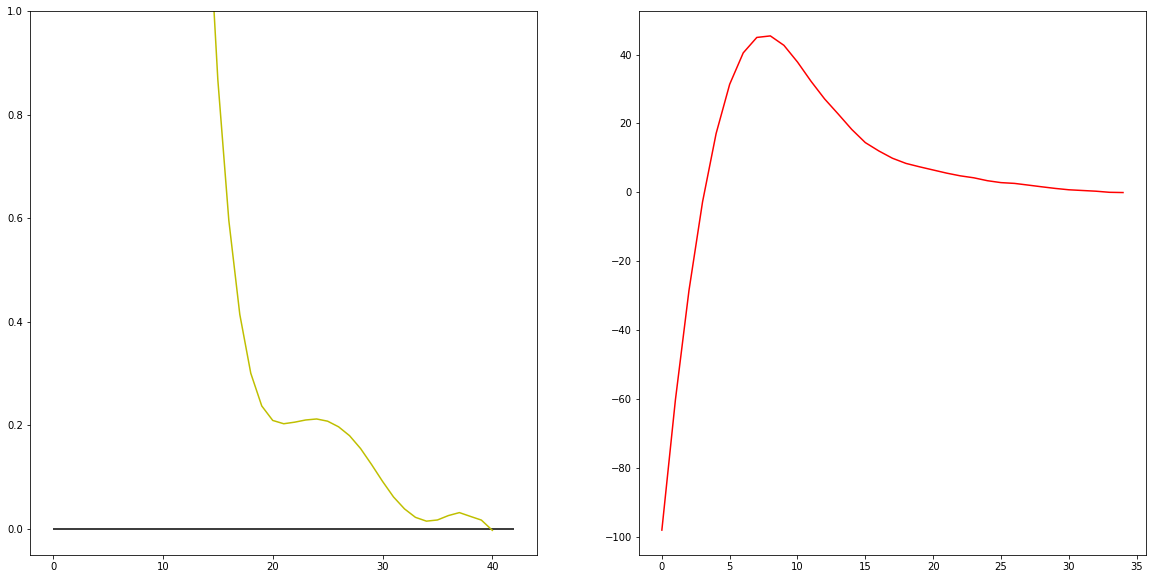

In [1006]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
# plt.plot(np.array(b_weight9[2:])*(6*0.1**3) , 'g')
# plt.plot(np.array(b_weight8[2:])*(6*0.1**3) , 'b')
# plt.plot(np.array(b_weight7[2:])*(6*0.1**3) , 'm')
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'y')
#axs[0].set_xlim(10,)
axs[0].set_ylim(-0.05,1.0)
axs[0].hlines(0.0, 0, 42)

axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'r')

# plt.ylim(-2,10)
# plt.hlines(0, 0, 42)
# plt.legend()


# rr = np.linspace(1.3, 5.65, 436)

# plt.plot(rr, [make_bspline(b_all[1:1+len(pair_knots)], p_knot, r) for r in rr])
# plt.xlim(1.3,)
# plt.ylim(-1.5,0.2)
# plt.xlim(rr[0], rr[-1])
# plt.hlines(0.0, rr[0], rr[-1])

In [1007]:
bounds

[slice(0, 200, 1),
 slice(200, 346, 1),
 slice(346, 472, 1),
 slice(472, 708, 1),
 slice(708, 841, 1),
 slice(841, 977, 1),
 slice(977, 1176, 1),
 slice(1176, 1267, 1),
 slice(1267, 1389, 1),
 slice(1389, 1395, 1),
 slice(0, 1595, 1)]

[-1139.221, 0.0, -1136.417, -1136.757, -1190.271, -1127.147]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


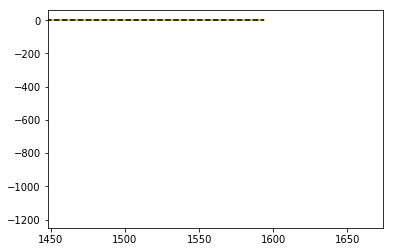

In [1008]:
plt.plot(energy(b_all, X), 'y')
#plt.plot(X.dot(b_weight4), 'm')
plt.plot(y, 'k--')
plt.xlim(1448,)
# plt.ylim(-1200,-1120)

#print(list(y[382:389]), list(X.dot(b_0)[382:389]))
# print([round(z, 3) for z in X.dot(b_weight9)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight8)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight7)[-6:]])


#print(bounds[index][0])
#print([round(z, 3) for z in X.dot(b_all)[-6:]])
print([round(z, 3) for z in energy(b_all, X)[bounds[-2]]])
print([round(z, 3) for z in y[bounds[-2]]])

#print([round(z, 3) for z in y[-6:]])

[-1139.221, 0.0, -1136.417, -1136.757, -1190.271, -1127.147]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


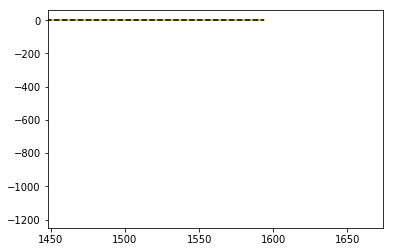

In [1009]:
plt.plot(energy(b_all, X), 'y')
#plt.plot(X.dot(b_weight4), 'm')
plt.plot(y, 'k--')
plt.xlim(1448,)
# plt.ylim(-1200,-1120)

#print(list(y[382:389]), list(X.dot(b_0)[382:389]))
# print([round(z, 3) for z in X.dot(b_weight9)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight8)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight7)[-6:]])


#print(bounds[index][0])
#print([round(z, 3) for z in X.dot(b_all)[-6:]])
print([round(z, 3) for z in energy(b_all, X)[bounds[-2]]])
print([round(z, 3) for z in y[bounds[-2]]])

#print([round(z, 3) for z in y[-6:]])

In [1010]:
print(bounds[:]), len(X[0])

[slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1395, 1), slice(0, 1595, 1)]


(None, 1595)

In [1011]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [1012]:
for i, stat in enumerate(stats_list[-1:]):
    Xallx, yallx, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)
    #X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1390, 1), slice(1390, 1395, 1), slice(1395, 1403, 1), slice(1403, 1413, 1), slice(1413, 1425, 1), slice(1425, 1431, 1)]
weights [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [1013]:
energy(b_all, Xallx)[bounds[-1]]

array([-1139.22071998,     0.        , -1136.41654356, -1136.75675424,
       -1190.27088557, -1127.1465613 ])

In [1014]:
yallx[bounds[-1]]

array([-1.13920000e+003, -2.96886796e-239, -1.13640101e+003,
       -1.13675082e+003, -1.19026118e+003, -1.12717470e+003])

In [1015]:
sys.getsizeof(Xallx[1])/sys.getsizeof(Xallx[0]), sys.getsizeof(b_all)

(366.98587373264036, 96)

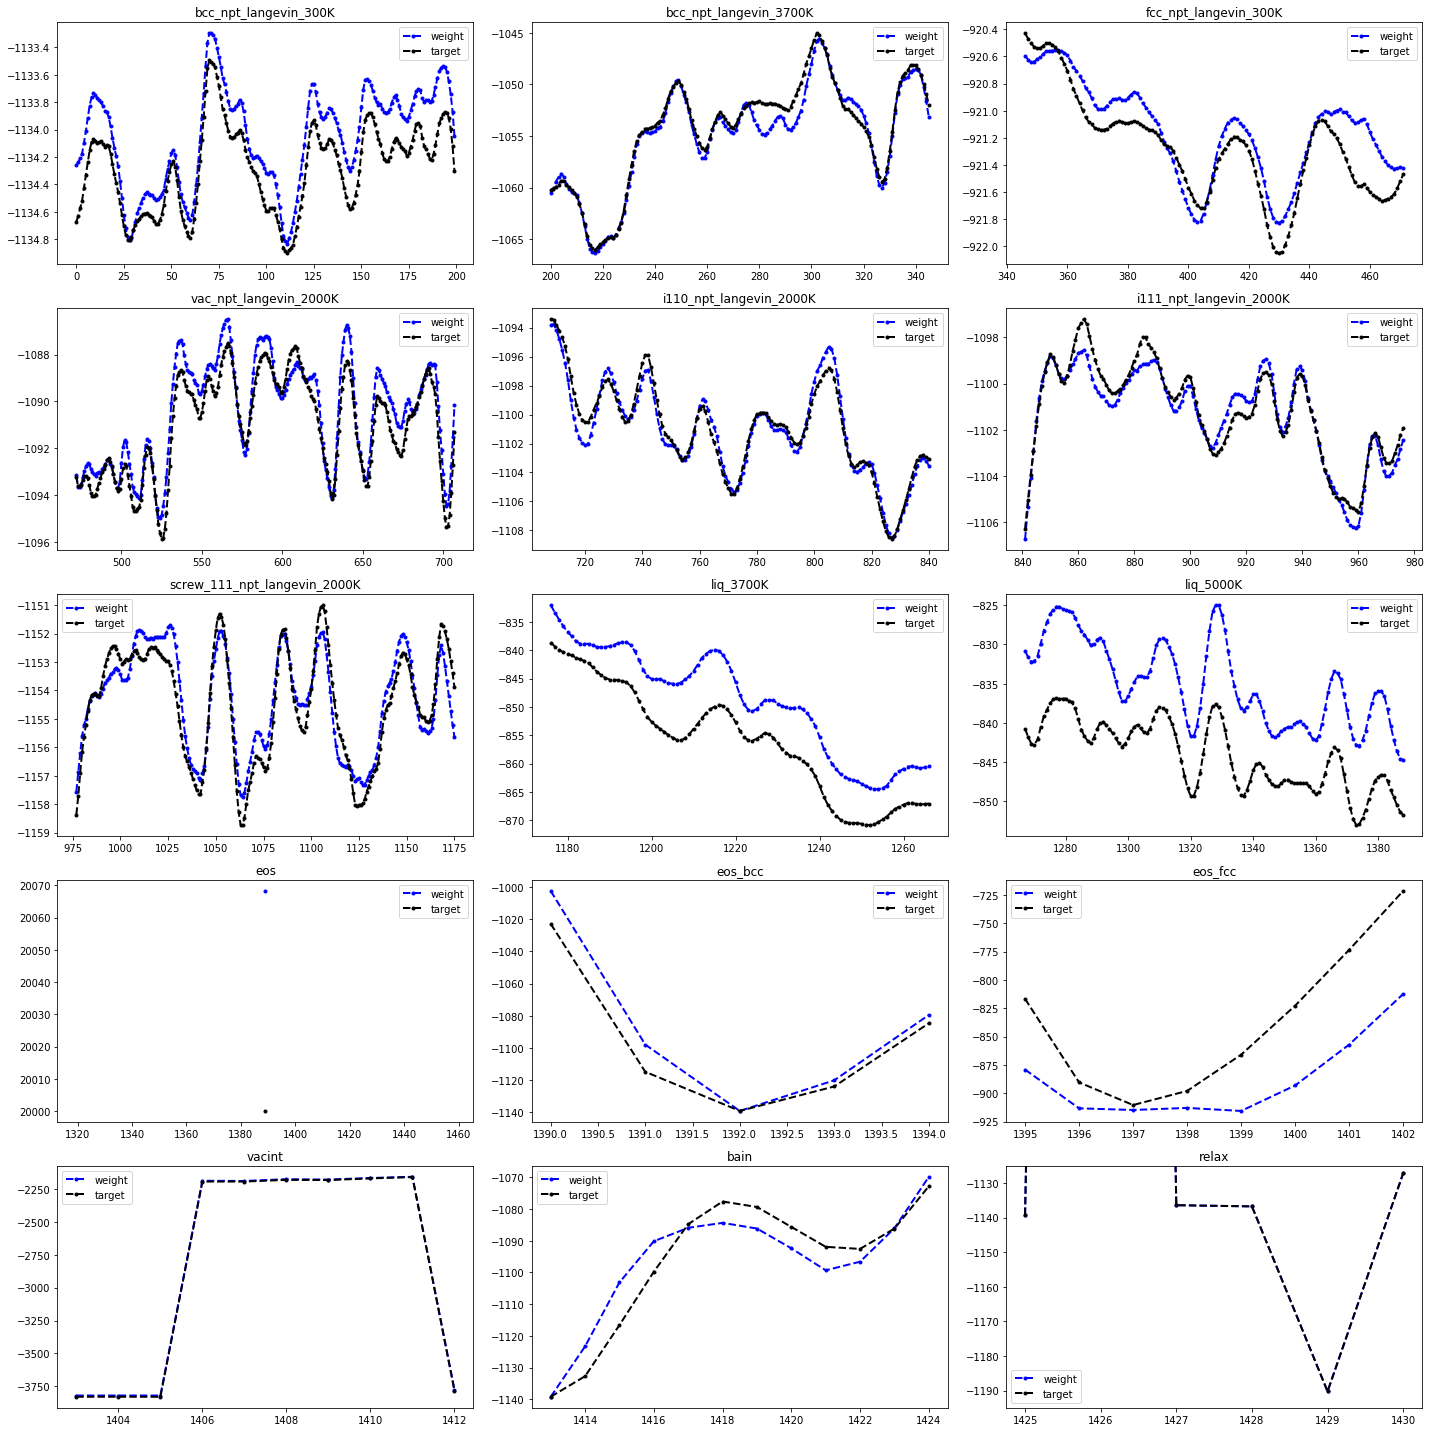

In [1016]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(len(Xallx[0])))[bounds[k]][:]
    #print(rr)

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
    axes[i,j].plot(rr, energy(b_all, Xallx)[bounds[k]][:], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight9)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yallx[bounds[k]][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
#     if trj == 'eos':
#         axes[i,j].set_ylim(-1195, -800)
#         axes[i,j].set_xlim(1395,1410)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [1017]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpfx = pickle.load(fi, encoding='latin1')

stats_bsplinex = tpf_to_bsplines(stats_tpfx)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targetsx = pickle.load(fi, encoding='latin1')

len 50


In [1018]:
len(stats_tpfx['relax']['energy'][0][2]), len(stats_bsplinex['relax']['energy'][0][2])

(50, 46)

In [1019]:
for key in targets.keys():
    targetsx[key]['weight'] = 1.0

In [1020]:
# mb_knots = list(np.linspace(3.75, 5.25, 16))
# pair_knots = list(np.linspace(1.05, 5.25, 43))
# #pair_knots = list(np.linspace(2.05, 5.25, 33))

# print(mb_knots)
# print(pair_knots)

# # Select knots for optimization
# # cycle over knots of selected models
# stats_listx = []
# for knot in mb_knots:
#     edens_knots = [knot]
#     stats = downselect(stats_bsplinex, pair_knots, edens_knots)
#     stats_listx.append(stats)

In [1021]:
#edens_knots = list(np.linspace(1.05, 4.25, 5))
edens_knots = list(np.linspace(1.05, 4.45, 35))
#edens_knots = list(np.linspace(1.05, 5.25, 43))
pair_knots = list(np.linspace(1.05, 5.05, 41))

print(edens_knots)
print(pair_knots)

stats_listx = [downselect(stats_bsplinex, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05]


In [1022]:
for i, stat in enumerate(stats_listx[-1:]):
    Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys)

bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1410, 1), slice(1410, 1418, 1), slice(1418, 1426, 1), slice(1426, 1436, 1), slice(1436, 1448, 1), slice(1448, 1454, 1)]
weights [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


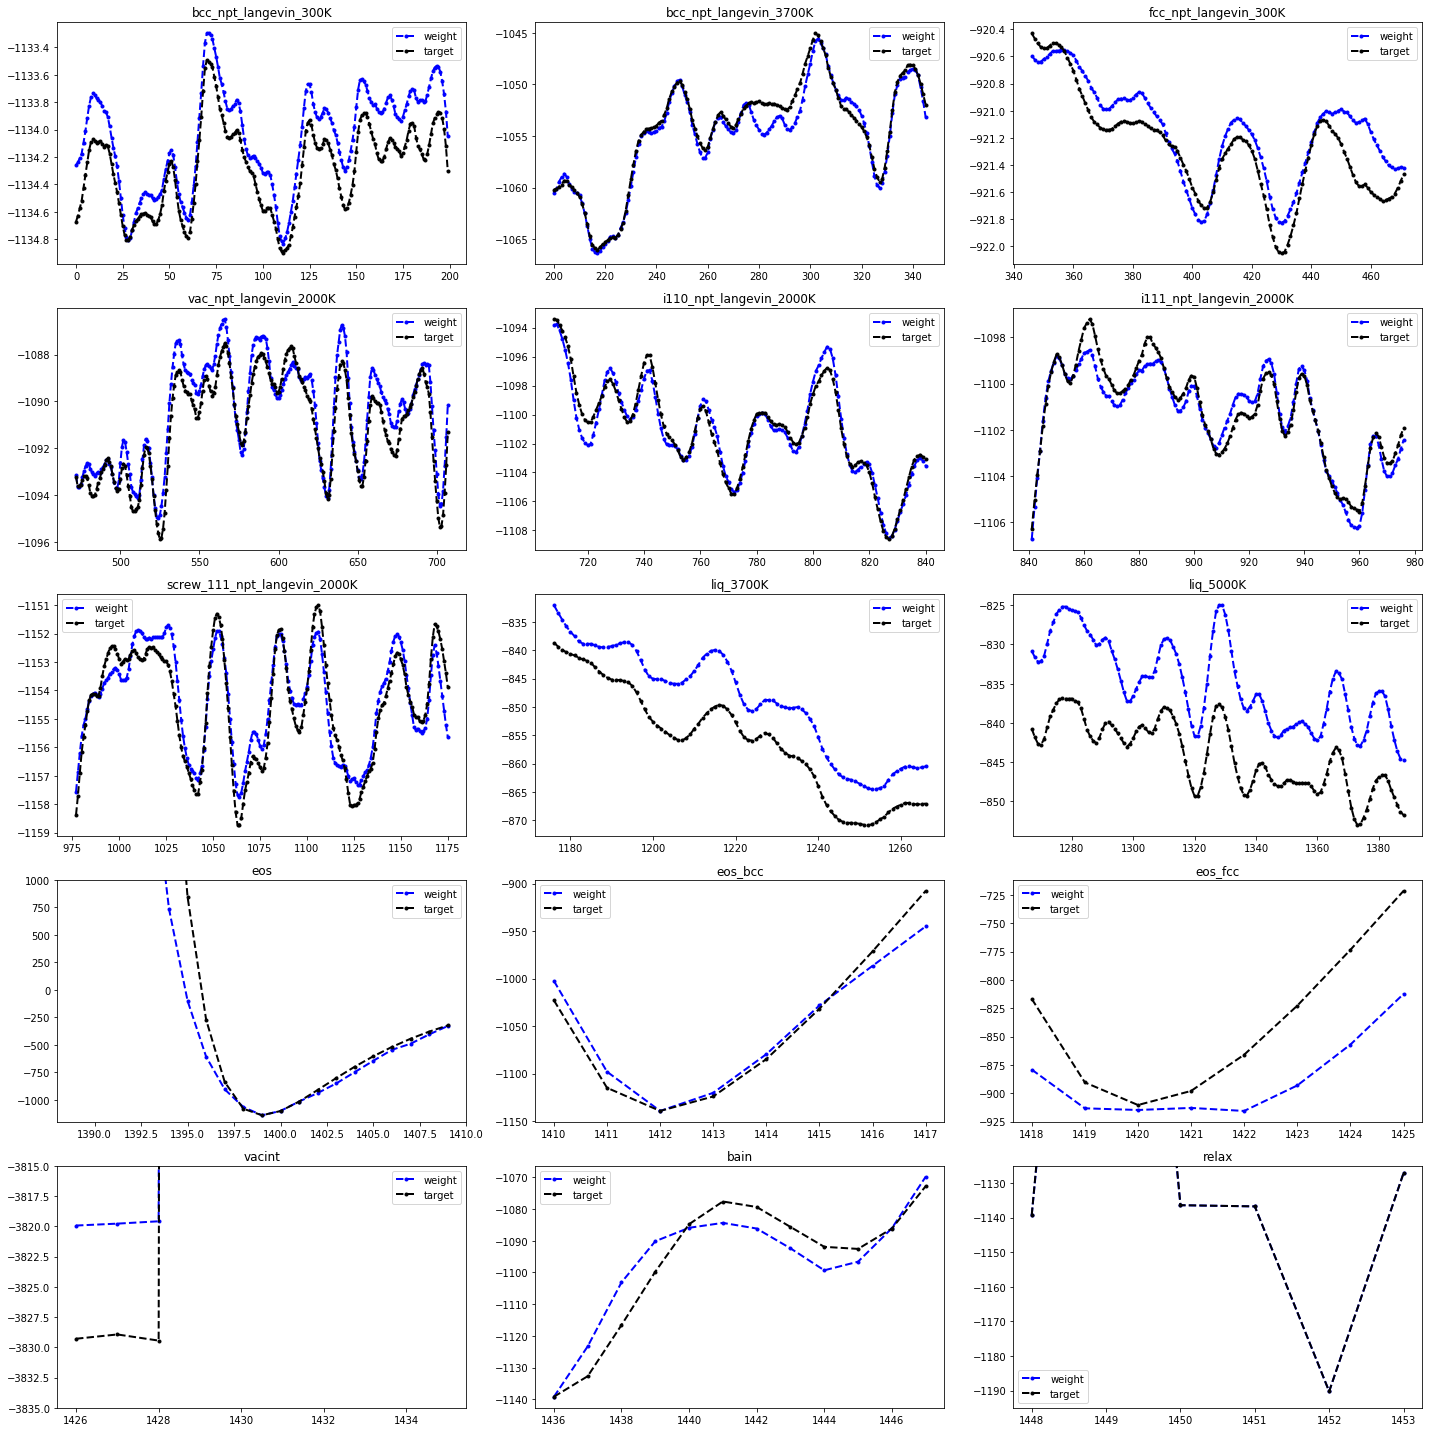

In [1061]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(len(Xall[0])))[bounds[k]][:]

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight7)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'b.--', lw=2, label='weight')

    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')
    axes[i,j].plot(rr, yall[bounds[k]][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(rr[0],1396)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [1033]:
p_knots = np.array(pair_knots)+0.4
print(p_knots)
e_knots = np.array(edens_knots)+0.4
print(e_knots)
n_edens = len(e_knots)

[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45]
[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85]


In [1034]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [1037]:
M = _bspline_coeffs_to_tpf(41)

In [1038]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[1:-n_edens]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.93218697e+03  4.29188567e+03  3.70184628e+03  3.16207069e+03
  2.67241286e+03  2.23241312e+03  1.84120353e+03  1.49739693e+03
  1.19949901e+03  9.45037368e+02  7.30974539e+02  5.53696640e+02
  4.09502469e+02  2.95334756e+02  2.08504723e+02  1.44628752e+02
  9.93512647e+01  6.90636120e+01  5.01185504e+01  3.95906645e+01
  3.49221072e+01  3.38567874e+01  3.43626467e+01  3.50677025e+01
  3.53918598e+01  3.46808894e+01  3.28628739e+01  2.99993817e+01
  2.58737651e+01  2.07372209e+01  1.53124852e+01  1.02912292e+01
  6.45323032e+00  3.72273665e+00  2.49955100e+00  2.87655572e+00
  4.29661572e+00  5.25132662e+00  4.03495089e+00  2.84617575e+00
 -4.50700625e-01]
[ 4.93218697e+03 -1.54368622e+04  1.61274254e+04 -5.62274833e+03
 -1.47906946e-01 -3.13620165e-01 -4.08286684e-01 -5.19216357e-01
 -1.07142531e-01 -9.78111874e-01 -5.65040881e-01 -5.76428841e-01
 -8.73166970e-02  6.43932880e-01  3.68489519e-01 -1.69483753e+00
  2.80375065e-02  7.46931302e-01 -3.85956855e-02  7.21828595e-01
  3.675

In [1042]:
Medens = _bspline_coeffs_to_tpf(35)

In [1044]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
ed11_ext = np.array(list(b_all[-n_edens:]))#*(6*0.1**3)
print(ed11_ext)
edens_coeff = Medens.dot(ed11_ext)
print(edens_coeff)

[-1.63236674e+04 -1.00230625e+04 -4.73618211e+03 -4.56614681e+02
  2.84693539e+03  5.22851002e+03  6.74728892e+03  7.49283438e+03
  7.56680155e+03  7.11094301e+03  6.30462462e+03  5.37181941e+03
  4.51944424e+03  3.79160282e+03  3.04592461e+03  2.40913848e+03
  2.00403383e+03  1.65292188e+03  1.40248147e+03  1.23820803e+03
  1.08526456e+03  9.32618196e+02  8.02298533e+02  7.06859166e+02
  5.67295665e+02  4.74458721e+02  4.36526968e+02  3.55533757e+02
  2.72760877e+02  1.94164404e+02  1.28589424e+02  9.38211485e+01
  5.96709374e+01  6.22492297e+00 -5.52559051e+00]
[-1.63236674e+04  5.52716069e+04 -6.25859363e+04  2.36444082e+04
  2.48841097e+01  2.27463178e+01  5.13777578e+00  3.03826064e+01
  1.20928483e+01  4.00974110e+01  3.76133057e+01  4.46071681e+01
 -1.70561970e+01 -1.62813120e+02 -1.86474253e+02  2.69099401e+02
 -3.93947988e+00 -3.00478168e+02  2.24367638e+02 -6.11834429e+01
 -6.03324114e+01  6.38041398e+01  3.30624420e+01 -9.47598615e+00
 -9.15580302e+01  1.69855123e+02 -8.2672

In [1046]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
print(len(tpf_coeff), len(p_knot))
e_knot = [1.05, 1.15, 1.25, 1.35] + list(e_knots)
print(len(edens_coeff), len(e_knot))

45 45
39 39


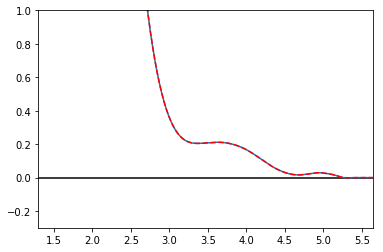

In [1047]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-0.3,1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

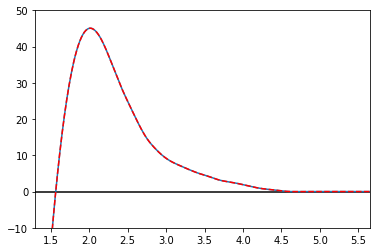

In [1050]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[-n_edens:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[-n_edens:], e_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, edens_coeff, e_knot) for r in rr], 'r--')
plt.ylim(-10,50)
plt.xlim(4,5)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [1051]:
tpf_coeff

array([ 4.93218697e+03, -1.54368622e+04,  1.61274254e+04, -5.62274833e+03,
       -1.47906946e-01, -3.13620165e-01, -4.08286684e-01, -5.19216357e-01,
       -1.07142531e-01, -9.78111874e-01, -5.65040881e-01, -5.76428841e-01,
       -8.73166970e-02,  6.43932880e-01,  3.68489519e-01, -1.69483753e+00,
        2.80375065e-02,  7.46931302e-01, -3.85956855e-02,  7.21828595e-01,
        3.67567888e-01,  3.01756357e-01,  2.24032521e-01,  6.60075966e-01,
        7.91887470e-01, -7.41342637e-02,  5.82311980e-01,  1.33485657e-01,
       -2.78216008e-01,  4.67844416e-01,  4.71539397e-01, -3.10649519e-02,
        8.81061163e-02, -8.55529107e-01,  4.75554556e-01, -3.06920406e-01,
       -6.50017472e-01, -9.51269250e-01, -1.97333172e-01,  3.90442475e+00,
       -4.33438903e+00,  7.99138005e+00, -1.00539559e+01,  4.64897825e+00,
       -4.50700625e-01])

In [1052]:
edens_coeff

array([-1.63236674e+04,  5.52716069e+04, -6.25859363e+04,  2.36444082e+04,
        2.48841097e+01,  2.27463178e+01,  5.13777578e+00,  3.03826064e+01,
        1.20928483e+01,  4.00974110e+01,  3.76133057e+01,  4.46071681e+01,
       -1.70561970e+01, -1.62813120e+02, -1.86474253e+02,  2.69099401e+02,
       -3.93947988e+00, -3.00478168e+02,  2.24367638e+02, -6.11834429e+01,
       -6.03324114e+01,  6.38041398e+01,  3.30624420e+01, -9.47598615e+00,
       -9.15580302e+01,  1.69855123e+02, -8.26720584e+01, -1.06145284e+02,
        1.39248441e+02, -3.53257164e+01,  2.88901244e+00,  8.94012477e+00,
       -4.79738520e+01,  1.02747729e+01,  8.09051718e+01, -8.54107011e+01,
        1.61770241e+00,  2.83272850e+01, -5.52559051e+00])

In [1053]:
params = {
    'hyperparams':{'pair':[], 'edens':[]},
    'params':{'pair':[], 'edens':[]}}
params['hyperparams']['pair'] = p_knot
params['params']['pair'] = tpf_coeff
params['hyperparams']['edens'] = e_knot
params['params']['edens'] = edens_coeff
params['params']['embed'] = [-1.0, b_all[0]]

In [1054]:
param_list = [params]
param_list

[{'hyperparams': {'pair': [1.05,
    1.15,
    1.25,
    1.35,
    1.4500000000000002,
    1.5500000000000003,
    1.65,
    1.75,
    1.85,
    1.9500000000000002,
    2.0500000000000003,
    2.15,
    2.25,
    2.35,
    2.4499999999999997,
    2.5500000000000003,
    2.65,
    2.75,
    2.85,
    2.9499999999999997,
    3.0500000000000003,
    3.15,
    3.25,
    3.35,
    3.4499999999999997,
    3.5500000000000003,
    3.65,
    3.7500000000000004,
    3.85,
    3.9499999999999997,
    4.050000000000001,
    4.15,
    4.250000000000001,
    4.3500000000000005,
    4.45,
    4.550000000000001,
    4.65,
    4.750000000000001,
    4.8500000000000005,
    4.95,
    5.050000000000001,
    5.15,
    5.250000000000001,
    5.3500000000000005,
    5.45],
   'edens': [1.05,
    1.15,
    1.25,
    1.35,
    1.4500000000000002,
    1.5500000000000003,
    1.65,
    1.75,
    1.85,
    1.9500000000000002,
    2.0500000000000003,
    2.15,
    2.25,
    2.35,
    2.4499999999999997,
    2.550

In [1055]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

for params in param_list[-1:]:
    params_to_pickle(params, file_name)#, encoding='latin1', protocol=3)

No existing params file, creating a new one.


In [1056]:
with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)
#params_store[-1]

In [1057]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))

print('edens') 
for c, k in zip(edens_coeff, e_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
        
print('embed')
print(-1.0, b_all[0])
#print(-4.42166597e-01,  1.12818607e-04)
#print(-4.49779872e-01,  1.09664665e-04)

pair
+4932.1869694107445d0*(1.05d0 - r)**3*H(1.05d0 - r)
-15436.862211702473d0*(1.15d0 - r)**3*H(1.15d0 - r)
+16127.425437218692d0*(1.25d0 - r)**3*H(1.25d0 - r)
-5622.748325763732d0*(1.35d0 - r)**3*H(1.35d0 - r)
-0.14790694554176298d0*(1.45d0 - r)**3*H(1.45d0 - r)
-0.31362016483035404d0*(1.55d0 - r)**3*H(1.55d0 - r)
-0.4082866838243717d0*(1.65d0 - r)**3*H(1.65d0 - r)
-0.5192163570127377d0*(1.75d0 - r)**3*H(1.75d0 - r)
-0.10714253090918646d0*(1.85d0 - r)**3*H(1.85d0 - r)
-0.9781118739119847d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.5650408805331608d0*(2.05d0 - r)**3*H(2.05d0 - r)
-0.5764288405721345d0*(2.15d0 - r)**3*H(2.15d0 - r)
-0.08731669696499011d0*(2.25d0 - r)**3*H(2.25d0 - r)
+0.6439328795590882d0*(2.35d0 - r)**3*H(2.35d0 - r)
+0.3684895193171087d0*(2.45d0 - r)**3*H(2.45d0 - r)
-1.6948375332796104d0*(2.55d0 - r)**3*H(2.55d0 - r)
+0.028037506535497414d0*(2.65d0 - r)**3*H(2.65d0 - r)
+0.7469313024511166d0*(2.75d0 - r)**3*H(2.75d0 - r)
-0.03859568546306491d0*(2.85d0 - r)**3*H(2.85d0 - r)
+

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']

Parameters given to Yuri:

Embedding:
-4.42166597e-01,  1.12818607e-04,
Pair potential coefficients: Knots ending at 5.65 with steps of 0.1 A:

4.51698420e+03,  3.75910139e+03, 3.06924350e+03,  2.44738802e+03,  1.89346739e+03,  1.40738478e+03,
9.89029865e+02,  6.38294633e+02,  3.55089127e+02,  1.39357269e+02,
       -9.60824592e+00, -9.86104306e+01, -1.44135463e+02, -1.65813774e+02,
       -1.73239670e+02, -1.65893890e+02, -1.60198554e+02, -1.46418160e+02,
       -1.35762684e+02, -1.25923736e+02, -1.10532902e+02, -8.90260796e+01,
       -6.86880677e+01, -5.45283774e+01, -4.52604866e+01, -3.77851927e+01,
       -3.19692325e+01, -2.76892221e+01, -2.45864649e+01, -2.09702658e+01,
       -1.96949536e+01, -2.16298673e+01, -1.49970585e+01, -9.26360379e+00,
       -1.22233430e+01, -5.85168131e+00,  1.60207091e+00,  3.86904582e+00,
       -2.36332511e+00,  2.69685169e+00, -1.92552950e+00, -5.24093457e-01,
        1.38798423e-01